In [1]:
import pandas as pd
df = pd.read_csv("/home/marko/projects/tf216/pg/pgfinal.csv")

In [2]:
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
for idx, col_name in enumerate(df.columns):
    print(f"Index: {idx}, Column Name: {col_name}")

Index: 0, Column Name: RHUM
Index: 1, Column Name: MAX
Index: 2, Column Name: MIN
Index: 3, Column Name: TEMP
Index: 4, Column Name: WDSP


In [3]:
ry = pd.read_csv("/home/marko/projects/tf216/pg/rypg.csv")
ry['DATE'] = pd.to_datetime(ry['DATE'])
ry = ry.set_index('DATE')
ry.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 365 entries, 2024-01-01 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RHUM    365 non-null    float64
 1   MAX     365 non-null    float64
 2   MIN     365 non-null    float64
 3   TEMP    365 non-null    float64
 4   WDSP    365 non-null    float64
dtypes: float64(5)
memory usage: 17.1 KB


In [4]:
df_train = df["2002-01-01":"2019-12-31"]
df_valid = df["2020-01-01":"2023-12-31"]
df_test = df["2024-01-01":"2024-12-31"]

In [5]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf

def split_inputs_and_targets(time_series):
    ahead = 365
    target_cols = tf.constant([1, 2, 3], dtype=tf.int32)
    X = time_series[:, :-ahead]
    Y = tf.gather(time_series[:, -ahead:], target_cols, axis=-1)
    return X, Y


seq_length = 365
train_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_train.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=True,
	seed=42
).map(split_inputs_and_targets)


valid_ds = tf.keras.utils.timeseries_dataset_from_array(
	df_valid.to_numpy(),
	targets=None,
	sequence_length=seq_length + 365,
	batch_size=32,
	shuffle=False
).map(split_inputs_and_targets)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df_test = df_test.drop(pd.to_datetime("2024-02-29"))

X = df_valid.to_numpy()[np.newaxis, :seq_length]
Y_test = df_test.iloc[:, [1, 2, 3]].to_numpy()

Y_ref = ry.iloc[:, [1, 2, 3]].to_numpy()

mae_ref = mean_absolute_error(Y_test[:, 2], Y_ref[:, 2])
print(f'Mean Absolute Error (MAE): {mae_ref:.3f}')

rmse_ref = np.sqrt(mean_squared_error(Y_test[:, 2], Y_ref[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_ref:.3f}')

Mean Absolute Error (MAE): 3.321
Root Mean Squared Error (RMSE): 4.163


In [16]:
lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_32 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=70)
lstm_32.save('models/lstm_32.keras')

Epoch 1/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 334.5402 - mae: 15.8042 - val_loss: 207.8527 - val_mae: 11.7050
Epoch 2/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 172.6338 - mae: 10.5777 - val_loss: 125.6831 - val_mae: 8.7754
Epoch 3/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 110.3263 - mae: 8.4074 - val_loss: 91.0155 - val_mae: 7.6427
Epoch 4/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 85.0373 - mae: 7.5767 - val_loss: 77.4170 - val_mae: 7.2879
Epoch 5/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 75.6734 - mae: 7.2922 - val_loss: 72.6017 - val_mae: 7.1892
Epoch 6/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.6588 - mae: 7.2045 - val_loss: 71.0805 - val_mae: 7.1684
Epoch 7/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 71.7860 - mae: 7.1816 - val_loss: 70.6410 - val_mae: 7.1677
Epoch 8/70
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.6480 - mae: 7.1801 - val_loss: 70.5227 - val_mae: 7.1697
Epoch 9/70
183/183 ━━━━━

In [19]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_2 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 12.2410 - mae: 2.7648 - val_loss: 11.1114 - val_mae: 2.6796
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 12.0788 - mae: 2.7466 - val_loss: 10.7722 - val_mae: 2.6287
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.9663 - mae: 2.7327 - val_loss: 10.8931 - val_mae: 2.6461
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.8962 - mae: 2.7242 - val_loss: 11.2811 - val_mae: 2.6938
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.8352 - mae: 2.7177 - val_loss: 10.6471 - val_mae: 2.6155
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.7421 - mae: 2.7059 - val_loss: 10.9216 - val_mae: 2.6463
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 11.7109 - mae: 2.7034 - val_loss: 10.7288 - val_mae: 2.6259
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.6596 - mae: 2.6970 - val_loss: 10.5305 - val_mae: 2.5999
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [22]:
from tensorflow.keras.models import load_model
lstm_32 = load_model('models/lstm_32.keras')
history_lstm_32_3 = lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_32.save('models/lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 11.5637 - mae: 2.6849 - val_loss: 10.7527 - val_mae: 2.6293
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.5355 - mae: 2.6821 - val_loss: 10.2620 - val_mae: 2.5629
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 11.4584 - mae: 2.6729 - val_loss: 10.6873 - val_mae: 2.6171
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.4220 - mae: 2.6679 - val_loss: 10.7853 - val_mae: 2.6287
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.4107 - mae: 2.6675 - val_loss: 10.7406 - val_mae: 2.6214
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.4545 - mae: 2.6726 - val_loss: 10.7746 - val_mae: 2.6236
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.3104 - mae: 2.6554 - val_loss: 12.4072 - val_mae: 2.8205
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.2917 - mae: 2.6525 - val_loss: 10.8414 - val_mae: 2.6345
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [23]:
lstm_32 = tf.keras.models.load_model('models/lstm_32.keras')

Y_lstm_32 = lstm_32.predict(X)  # shape: (1, 365, 3)
Y_lstm_32 = Y_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_32_pred.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step


In [ ]:
mae_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_32:.3f}')

rmse_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_32:.3f}')

Mean Absolute Error (MAE): 2.964
Root Mean Squared Error (RMSE): 3.628


In [7]:
conv_lstm_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_32 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 331.3197 - mae: 15.7107 - val_loss: 215.9732 - val_mae: 11.9921
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 179.8329 - mae: 10.8298 - val_loss: 131.6249 - val_mae: 8.9846
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 114.9220 - mae: 8.5660 - val_loss: 94.1486 - val_mae: 7.7335
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 87.3080 - mae: 7.6466 - val_loss: 78.8259 - val_mae: 7.3207
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 76.7029 - mae: 7.3237 - val_loss: 73.1509 - val_mae: 7.1993
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 72.9977 - mae: 7.2144 - val_loss: 71.2671 - val_mae: 7.1701
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 71.8949 - mae: 7.1838 - val_loss: 70.7021 - val_mae: 7.1673
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 71.6496 - mae: 7.1804 - val_loss: 70.5400 - val_mae: 7.1693
Epoch 9/60
183/183 ━━━━━━

In [8]:
from tensorflow.keras.models import load_model
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_2 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 13.1463 - mae: 2.8705 - val_loss: 11.5442 - val_mae: 2.7339
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 12.7007 - mae: 2.8212 - val_loss: 11.6461 - val_mae: 2.7453
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 12.4071 - mae: 2.7867 - val_loss: 11.4963 - val_mae: 2.7219
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 12.2185 - mae: 2.7646 - val_loss: 11.6530 - val_mae: 2.7397
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.0724 - mae: 2.7477 - val_loss: 11.3292 - val_mae: 2.7001
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 11.9611 - mae: 2.7345 - val_loss: 11.2751 - val_mae: 2.6931
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 11.8463 - mae: 2.7208 - val_loss: 11.2176 - val_mae: 2.6869
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.7820 - mae: 2.7133 - val_loss: 11.2400 - val_mae: 2.6891
Epoch 9/10
183/183 ━━━━━━━━━━━━━━

In [11]:
conv_lstm_32 = load_model('models/conv_lstm_32.keras')
history_conv_lstm_32_3 = conv_lstm_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_32.save('models/conv_lstm_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 11.6011 - mae: 2.6902 - val_loss: 10.9328 - val_mae: 2.6487
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.5245 - mae: 2.6820 - val_loss: 10.6628 - val_mae: 2.6111
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.4726 - mae: 2.6749 - val_loss: 10.6011 - val_mae: 2.5987
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.3848 - mae: 2.6637 - val_loss: 10.5941 - val_mae: 2.5986
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.3591 - mae: 2.6618 - val_loss: 10.4550 - val_mae: 2.5782
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.3106 - mae: 2.6552 - val_loss: 10.5575 - val_mae: 2.5913
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.2787 - mae: 2.6517 - val_loss: 10.4276 - val_mae: 2.5783
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.2124 - mae: 2.6431 - val_loss: 10.5522 - val_mae: 2.5921
Epoch 9/10
183/183 ━━━━━━━━━━━━━━

In [12]:
conv_lstm_32 = tf.keras.models.load_model('models/conv_lstm_32.keras')

Y_conv_lstm_32 = conv_lstm_32.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_32 = Y_conv_lstm_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_32_pred.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step


In [13]:
mae_conv_lstm_32 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_32:.3f}')

rmse_conv_lstm_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_32:.3f}')

Mean Absolute Error (MAE): 2.828
Root Mean Squared Error (RMSE): 3.469


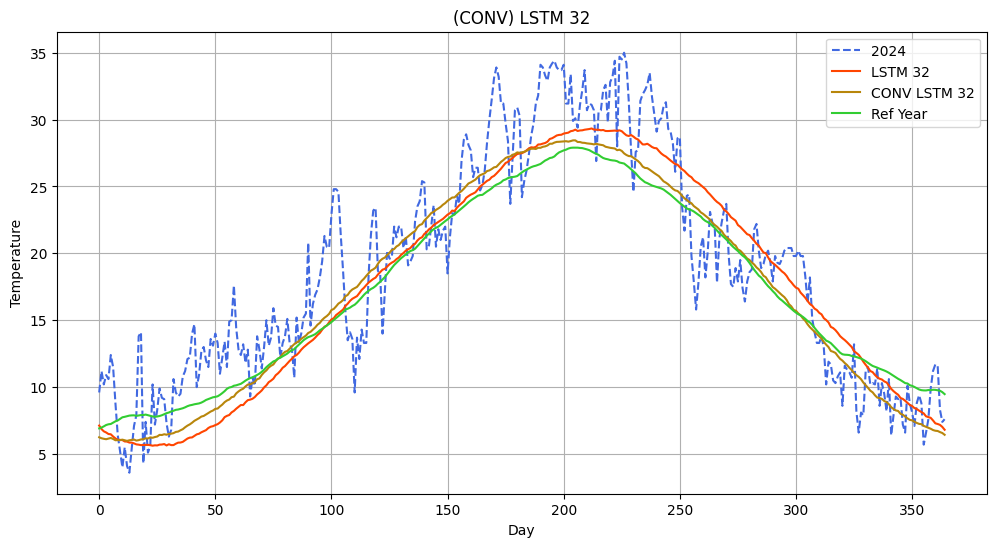

In [57]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_32[:, 2], label="LSTM 32", color='orangered')
plt.plot(x, Y_conv_lstm_32[:, 2], label="CONV LSTM 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [13]:
lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_64 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_64.save('models/lstm_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 295.0111 - mae: 14.5395 - val_loss: 125.2629 - val_mae: 8.7612
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 103.2077 - mae: 8.1724 - val_loss: 77.2834 - val_mae: 7.2855
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 74.8521 - mae: 7.2688 - val_loss: 71.1262 - val_mae: 7.1690
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 71.8516 - mae: 7.1860 - val_loss: 70.5399 - val_mae: 7.1695
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 71.6212 - mae: 7.1816 - val_loss: 70.4886 - val_mae: 7.1712
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 71.6325 - mae: 7.1833 - val_loss: 70.4982 - val_mae: 7.1719
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.6071 - mae: 7.1805 - val_loss: 70.5074 - val_mae: 7.1722
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 71.6105 - mae: 7.1806 - val_loss: 70.5130 - val_mae: 7.1722
Epoch 9/60
183/183 ━━━━━━━━━

In [14]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_2 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 22.0303 - mae: 3.7490 - val_loss: 22.3547 - val_mae: 3.7952
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 21.5143 - mae: 3.7064 - val_loss: 20.8309 - val_mae: 3.6591
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 21.1347 - mae: 3.6675 - val_loss: 19.5302 - val_mae: 3.5677
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 20.7959 - mae: 3.6380 - val_loss: 19.7024 - val_mae: 3.5694
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 20.4948 - mae: 3.6087 - val_loss: 19.9856 - val_mae: 3.5920
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 20.3007 - mae: 3.5876 - val_loss: 19.5287 - val_mae: 3.5538
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 19.3029 - mae: 3.4962 - val_loss: 18.0323 - val_mae: 3.4110
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 18.7876 - mae: 3.4458 - val_loss: 18.8441 - val_mae: 3.4632
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_3 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 17.7712 - mae: 3.3470 - val_loss: 16.3840 - val_mae: 3.2473
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 17.5686 - mae: 3.3237 - val_loss: 16.2579 - val_mae: 3.2297
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 16.9114 - mae: 3.2591 - val_loss: 16.4149 - val_mae: 3.2313
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 16.8146 - mae: 3.2459 - val_loss: 16.0694 - val_mae: 3.2092
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 16.5884 - mae: 3.2251 - val_loss: 16.8097 - val_mae: 3.2750
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 16.1999 - mae: 3.1847 - val_loss: 15.0398 - val_mae: 3.1141
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 15.8215 - mae: 3.1485 - val_loss: 15.3666 - val_mae: 3.1498
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 15.9219 - mae: 3.1543 - val_loss: 15.5378 - val_mae: 3.1678
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [16]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_4 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 15.1834 - mae: 3.0806 - val_loss: 14.5398 - val_mae: 3.0630
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 14.8059 - mae: 3.0422 - val_loss: 15.0323 - val_mae: 3.1173
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 14.6538 - mae: 3.0297 - val_loss: 15.4145 - val_mae: 3.1614
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 14.5901 - mae: 3.0216 - val_loss: 15.0990 - val_mae: 3.1171
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 14.6905 - mae: 3.0290 - val_loss: 13.5161 - val_mae: 2.9576
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 14.1827 - mae: 2.9783 - val_loss: 14.2417 - val_mae: 3.0336
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.8983 - mae: 2.9476 - val_loss: 14.7645 - val_mae: 3.0893
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 14.1338 - mae: 2.9716 - val_loss: 13.9501 - val_mae: 2.9997
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [18]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_5 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 13.6037 - mae: 2.9147 - val_loss: 13.6027 - val_mae: 2.9629
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.8292 - mae: 2.9384 - val_loss: 13.5679 - val_mae: 2.9551
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 13.5186 - mae: 2.9070 - val_loss: 13.8684 - val_mae: 2.9939
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.3057 - mae: 2.8826 - val_loss: 13.0094 - val_mae: 2.8961
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.3639 - mae: 2.8882 - val_loss: 12.6412 - val_mae: 2.8571
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.2574 - mae: 2.8756 - val_loss: 12.7856 - val_mae: 2.8779
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.2523 - mae: 2.8780 - val_loss: 13.1799 - val_mae: 2.9132
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.2181 - mae: 2.8738 - val_loss: 13.8544 - val_mae: 2.9887
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [20]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_6 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 13.0861 - mae: 2.8573 - val_loss: 12.7729 - val_mae: 2.8765
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.8500 - mae: 2.8326 - val_loss: 13.7734 - val_mae: 2.9678
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.8491 - mae: 2.8320 - val_loss: 12.8063 - val_mae: 2.8718
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.8926 - mae: 2.8374 - val_loss: 12.8589 - val_mae: 2.8790
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.8163 - mae: 2.8275 - val_loss: 12.7345 - val_mae: 2.8634
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.6846 - mae: 2.8139 - val_loss: 12.9061 - val_mae: 2.8854
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.7082 - mae: 2.8166 - val_loss: 12.5571 - val_mae: 2.8467
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 12.7943 - mae: 2.8251 - val_loss: 12.2470 - val_mae: 2.8137
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [22]:
from tensorflow.keras.models import load_model
lstm_64 = load_model('models/lstm_64.keras')
history_lstm_64_7 = lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_64.save('models/lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 12.5738 - mae: 2.8007 - val_loss: 12.7070 - val_mae: 2.8651
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 12.6459 - mae: 2.8073 - val_loss: 12.2836 - val_mae: 2.8142
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.4513 - mae: 2.7866 - val_loss: 12.3446 - val_mae: 2.8220
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 12.4678 - mae: 2.7879 - val_loss: 12.9879 - val_mae: 2.8950
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.4244 - mae: 2.7845 - val_loss: 12.1065 - val_mae: 2.7983
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12.3713 - mae: 2.7769 - val_loss: 12.3884 - val_mae: 2.8261
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 12.4524 - mae: 2.7859 - val_loss: 12.4405 - val_mae: 2.8329
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 12.3548 - mae: 2.7771 - val_loss: 12.6233 - val_mae: 2.8521
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [23]:
lstm_64 = tf.keras.models.load_model('models/lstm_64.keras')

Y_lstm_64 = lstm_64.predict(X)  # shape: (1, 365, 3)
Y_lstm_64 = Y_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_64_pred.csv')

mae_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_64:.3f}')

rmse_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Mean Absolute Error (MAE): 2.885
Root Mean Squared Error (RMSE): 3.534


In [64]:
conv_lstm_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_64 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 294.0674 - mae: 14.5255 - val_loss: 131.9209 - val_mae: 8.9952
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 107.6518 - mae: 8.3222 - val_loss: 78.9941 - val_mae: 7.3251
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 75.8200 - mae: 7.2966 - val_loss: 71.3692 - val_mae: 7.1711
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.9372 - mae: 7.1882 - val_loss: 70.5673 - val_mae: 7.1688
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.6607 - mae: 7.1827 - val_loss: 70.5004 - val_mae: 7.1711
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 71.6339 - mae: 7.1812 - val_loss: 70.5054 - val_mae: 7.1721
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 71.5991 - mae: 7.1810 - val_loss: 70.4947 - val_mae: 7.1720
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.6125 - mae: 7.1813 - val_loss: 70.5239 - val_mae: 7.1723
Epoch 9/60
183/183 ━━━━━━━━━━

In [66]:
from tensorflow.keras.models import load_model
conv_lstm_64 = load_model('models/conv_lstm_64.keras')
history_conv_lstm_64_2 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 11.3989 - mae: 2.6664 - val_loss: 13.5582 - val_mae: 2.9323
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.3326 - mae: 2.6592 - val_loss: 12.8556 - val_mae: 2.8479
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.2983 - mae: 2.6539 - val_loss: 12.4257 - val_mae: 2.8038
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.1940 - mae: 2.6416 - val_loss: 13.2621 - val_mae: 2.8802
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 11.1211 - mae: 2.6323 - val_loss: 12.8431 - val_mae: 2.8415
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.1460 - mae: 2.6361 - val_loss: 12.1032 - val_mae: 2.7671
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.0225 - mae: 2.6197 - val_loss: 12.9391 - val_mae: 2.8568
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 11.0551 - mae: 2.6239 - val_loss: 12.4760 - val_mae: 2.8049
Epoch 9/10
183/183 ━━━━━━━━━━━━━━

In [24]:
from tensorflow.keras.models import load_model
conv_lstm_64 = load_model('models/conv_lstm_64.keras')
history_conv_lstm_64_3 = conv_lstm_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_64.save('models/conv_lstm_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 10.9328 - mae: 2.6087 - val_loss: 12.7016 - val_mae: 2.8316
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.8353 - mae: 2.5964 - val_loss: 12.0395 - val_mae: 2.7618
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 10.8459 - mae: 2.5982 - val_loss: 11.8821 - val_mae: 2.7472
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.8334 - mae: 2.5964 - val_loss: 12.0646 - val_mae: 2.7668
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.8121 - mae: 2.5931 - val_loss: 12.1520 - val_mae: 2.7784
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.7612 - mae: 2.5869 - val_loss: 11.8746 - val_mae: 2.7460
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.7570 - mae: 2.5864 - val_loss: 11.8898 - val_mae: 2.7510
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.7975 - mae: 2.5906 - val_loss: 11.8733 - val_mae: 2.7438
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [25]:
conv_lstm_64 = tf.keras.models.load_model('models/conv_lstm_64.keras')

Y_conv_lstm_64 = conv_lstm_64.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_64 = Y_conv_lstm_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_64_pred.csv')

mae_conv_lstm_64 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_64:.3f}')

rmse_conv_lstm_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
Mean Absolute Error (MAE): 2.807
Root Mean Squared Error (RMSE): 3.450


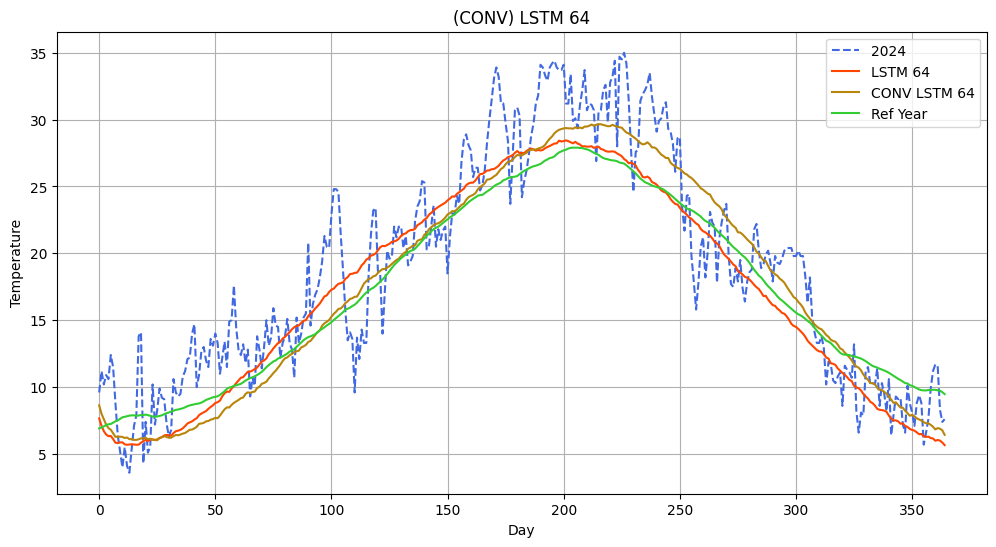

In [26]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_64[:, 2], label="LSTM 64", color='orangered')
plt.plot(x, Y_conv_lstm_64[:, 2], label="CONV LSTM 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_128.save('models/lstm_128.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 243.7725 - mae: 12.8497 - val_loss: 76.1572 - val_mae: 7.2620
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 73.5025 - mae: 7.2315 - val_loss: 70.5581 - val_mae: 7.1709
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 71.6689 - mae: 7.1841 - val_loss: 70.5474 - val_mae: 7.1735
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 71.6959 - mae: 7.1846 - val_loss: 70.5348 - val_mae: 7.1731
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.7268 - mae: 7.1871 - val_loss: 70.5577 - val_mae: 7.1740
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.6960 - mae: 7.1859 - val_loss: 70.5598 - val_mae: 7.1736
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 71.6975 - mae: 7.1848 - val_loss: 70.5945 - val_mae: 7.1747
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.6942 - mae: 7.1856 - val_loss: 70.5503 - val_mae: 7.1742
Epoch 9/60
183/183 ━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_2 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128.save('models/lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12.5177 - mae: 2.7979 - val_loss: 11.6160 - val_mae: 2.7413
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 12.3273 - mae: 2.7769 - val_loss: 11.2856 - val_mae: 2.7037
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 12.4104 - mae: 2.7867 - val_loss: 11.2693 - val_mae: 2.7058
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 12.1605 - mae: 2.7567 - val_loss: 11.1149 - val_mae: 2.6829
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 12.0152 - mae: 2.7396 - val_loss: 11.6917 - val_mae: 2.7516
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.8972 - mae: 2.7252 - val_loss: 11.3070 - val_mae: 2.7055
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.8420 - mae: 2.7191 - val_loss: 10.9601 - val_mae: 2.6657
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 11.8225 - mae: 2.7163 - val_loss: 12.0592 - val_mae: 2.7933
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [11]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_3 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128.save('models/lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 11.6268 - mae: 2.6920 - val_loss: 10.9828 - val_mae: 2.6651
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 11.5835 - mae: 2.6864 - val_loss: 11.6047 - val_mae: 2.7406
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 11.4532 - mae: 2.6705 - val_loss: 10.7754 - val_mae: 2.6352
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.4910 - mae: 2.6748 - val_loss: 11.3555 - val_mae: 2.7062
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 11.4512 - mae: 2.6708 - val_loss: 10.5957 - val_mae: 2.6120
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 11.5412 - mae: 2.6812 - val_loss: 11.5710 - val_mae: 2.7329
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 11.3946 - mae: 2.6636 - val_loss: 10.7423 - val_mae: 2.6306
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 11.3598 - mae: 2.6582 - val_loss: 10.6376 - val_mae: 2.6127
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [13]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_4 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128.save('models/lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 11.2990 - mae: 2.6508 - val_loss: 11.4686 - val_mae: 2.7176
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 11.3550 - mae: 2.6577 - val_loss: 11.1888 - val_mae: 2.6845
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.2476 - mae: 2.6440 - val_loss: 10.8722 - val_mae: 2.6438
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.2628 - mae: 2.6469 - val_loss: 11.3423 - val_mae: 2.7043
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.2359 - mae: 2.6429 - val_loss: 11.0632 - val_mae: 2.6687
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.2192 - mae: 2.6408 - val_loss: 11.3899 - val_mae: 2.7097
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 11.1649 - mae: 2.6346 - val_loss: 11.9926 - val_mae: 2.7811
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 11.1775 - mae: 2.6371 - val_loss: 11.3771 - val_mae: 2.7080
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
lstm_128 = load_model('models/lstm_128.keras')
history_lstm_128_5 = lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128.save('models/lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 10.9353 - mae: 2.6073 - val_loss: 11.8383 - val_mae: 2.7651
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.9322 - mae: 2.6070 - val_loss: 11.6670 - val_mae: 2.7463
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.0114 - mae: 2.6166 - val_loss: 11.5825 - val_mae: 2.7354
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 10.8994 - mae: 2.6028 - val_loss: 11.0537 - val_mae: 2.6695
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 10.9027 - mae: 2.6027 - val_loss: 11.3580 - val_mae: 2.7055
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.9091 - mae: 2.6037 - val_loss: 11.9354 - val_mae: 2.7749
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.9179 - mae: 2.6042 - val_loss: 11.6209 - val_mae: 2.7422
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.8515 - mae: 2.5965 - val_loss: 12.7654 - val_mae: 2.8764
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [16]:
lstm_128 = tf.keras.models.load_model('models/lstm_128.keras')

Y_lstm_128 = lstm_128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128 = Y_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128_pred.csv')

mae_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128:.3f}')

rmse_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Mean Absolute Error (MAE): 2.937
Root Mean Squared Error (RMSE): 3.632


In [17]:
conv_lstm_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 243.8676 - mae: 12.8637 - val_loss: 77.5617 - val_mae: 7.2931
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 74.0639 - mae: 7.2471 - val_loss: 70.5537 - val_mae: 7.1696
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 71.5979 - mae: 7.1795 - val_loss: 70.5486 - val_mae: 7.1739
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 71.7254 - mae: 7.1872 - val_loss: 70.5529 - val_mae: 7.1734
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 71.7234 - mae: 7.1864 - val_loss: 70.5659 - val_mae: 7.1743
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 71.7151 - mae: 7.1866 - val_loss: 70.5313 - val_mae: 7.1730
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 71.6578 - mae: 7.1831 - val_loss: 70.6758 - val_mae: 7.1759
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 71.5487 - mae: 7.1765 - val_loss: 69.7672 - val_mae: 7.1264
Epoch 9/40
183/183 ━━━━━━━━━━━

In [19]:
from tensorflow.keras.models import load_model
conv_lstm_128 = load_model('models/conv_lstm_128.keras')
history_conv_lstm_128_2 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 12.0701 - mae: 2.7462 - val_loss: 11.6255 - val_mae: 2.7412
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.9408 - mae: 2.7312 - val_loss: 11.8905 - val_mae: 2.7643
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.8650 - mae: 2.7223 - val_loss: 12.2248 - val_mae: 2.7994
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11.8597 - mae: 2.7209 - val_loss: 11.7390 - val_mae: 2.7527
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.6205 - mae: 2.6926 - val_loss: 11.5281 - val_mae: 2.7241
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.5813 - mae: 2.6867 - val_loss: 11.6538 - val_mae: 2.7458
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 11.4688 - mae: 2.6738 - val_loss: 11.5876 - val_mae: 2.7335
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11.4212 - mae: 2.6681 - val_loss: 11.3888 - val_mae: 2.7058
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [17]:
from tensorflow.keras.models import load_model
conv_lstm_128 = load_model('models/conv_lstm_128.keras')
history_conv_lstm_128_3 = conv_lstm_128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128.save('models/conv_lstm_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 11.2659 - mae: 2.6488 - val_loss: 11.6368 - val_mae: 2.7349
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.1882 - mae: 2.6386 - val_loss: 11.7290 - val_mae: 2.7556
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.2246 - mae: 2.6437 - val_loss: 10.9974 - val_mae: 2.6565
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.1012 - mae: 2.6281 - val_loss: 11.1584 - val_mae: 2.6790
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.1072 - mae: 2.6290 - val_loss: 11.2157 - val_mae: 2.6864
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 11.0932 - mae: 2.6268 - val_loss: 11.2080 - val_mae: 2.6843
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11.0750 - mae: 2.6252 - val_loss: 11.3647 - val_mae: 2.6990
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11.0430 - mae: 2.6212 - val_loss: 11.5330 - val_mae: 2.7292
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [18]:
conv_lstm_128 = tf.keras.models.load_model('models/conv_lstm_128.keras')

Y_conv_lstm_128 = conv_lstm_128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128 = Y_conv_lstm_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128_pred.csv')

mae_conv_lstm_128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128:.3f}')

rmse_conv_lstm_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Mean Absolute Error (MAE): 2.810
Root Mean Squared Error (RMSE): 3.445


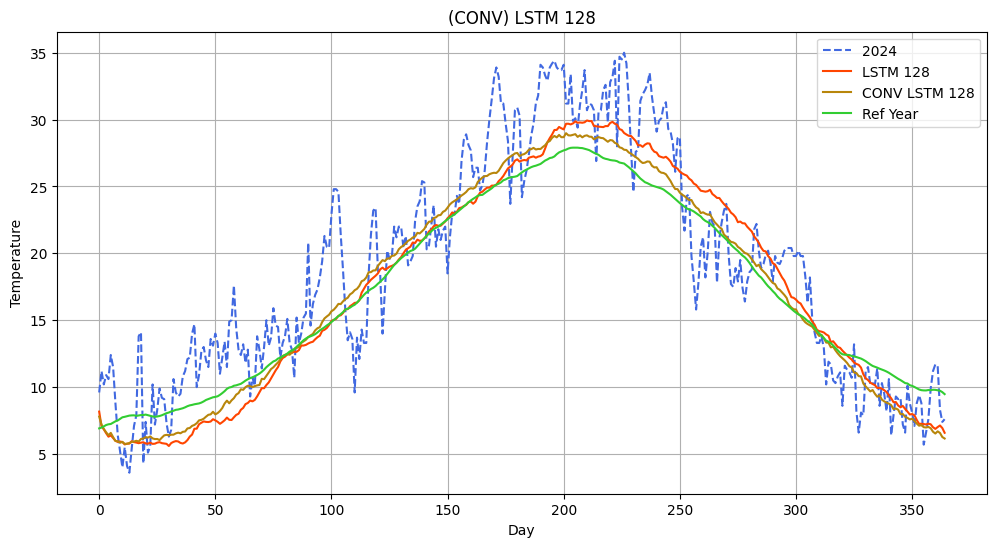

In [19]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128[:, 2], label="LSTM 128", color='orangered')
plt.plot(x, Y_conv_lstm_128[:, 2], label="CONV LSTM 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [13]:
lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_3232 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 331.7791 - mae: 15.7241 - val_loss: 213.3598 - val_mae: 11.9001
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 177.3348 - mae: 10.7432 - val_loss: 129.3003 - val_mae: 8.9028
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 112.9892 - mae: 8.4997 - val_loss: 92.8305 - val_mae: 7.6949
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 86.2911 - mae: 7.6162 - val_loss: 78.2026 - val_mae: 7.3061
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 76.2486 - mae: 7.3100 - val_loss: 72.8968 - val_mae: 7.1946
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 72.8532 - mae: 7.2104 - val_loss: 71.1773 - val_mae: 7.1692
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 71.9020 - mae: 7.1855 - val_loss: 70.6679 - val_mae: 7.1673
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 71.6538 - mae: 7.1801 - val_loss: 70.5314 - val_mae: 7.1696
Epoch 9/80
183/183 ━━━

In [15]:
from tensorflow.keras.models import load_model
lstm_3232 = load_model('models/lstm_3232.keras')
history_lstm_3232_2 = lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_3232.save('models/lstm_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 11.4064 - mae: 2.6637 - val_loss: 11.1010 - val_mae: 2.6924
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 11.4066 - mae: 2.6635 - val_loss: 11.2273 - val_mae: 2.7065
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 11.3738 - mae: 2.6606 - val_loss: 11.0453 - val_mae: 2.6851
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 11.3609 - mae: 2.6582 - val_loss: 11.0609 - val_mae: 2.6845
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 11.3564 - mae: 2.6580 - val_loss: 10.9987 - val_mae: 2.6786
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 11.3200 - mae: 2.6544 - val_loss: 10.9883 - val_mae: 2.6778
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 11.2956 - mae: 2.6512 - val_loss: 11.1452 - val_mae: 2.6951
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 11.2950 - mae: 2.6515 - val_loss: 11.0854 - val_mae: 2.6836
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [16]:
lstm_3232 = tf.keras.models.load_model('models/lstm_3232.keras')

Y_lstm_3232 = lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_3232 = Y_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_3232_pred.csv')

mae_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_3232:.3f}')

rmse_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step
Mean Absolute Error (MAE): 2.962
Root Mean Squared Error (RMSE): 3.624


In [24]:
conv_lstm_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_3232 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - loss: 331.4492 - mae: 15.7151 - val_loss: 214.9070 - val_mae: 11.9554
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 178.6863 - mae: 10.7899 - val_loss: 130.4474 - val_mae: 8.9432
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 113.9843 - mae: 8.5327 - val_loss: 93.4434 - val_mae: 7.7127
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 86.8118 - mae: 7.6333 - val_loss: 78.4827 - val_mae: 7.3127
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 76.4093 - mae: 7.3142 - val_loss: 73.0122 - val_mae: 7.1967
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 72.9437 - mae: 7.2131 - val_loss: 71.2177 - val_mae: 7.1697
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 71.8758 - mae: 7.1844 - val_loss: 70.6813 - val_mae: 7.1674
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 71.6561 - mae: 7.1804 - val_loss: 70.5389 - val_mae: 7.1695
Epoch 9/60
183/183 ━━━━━

In [25]:
from tensorflow.keras.models import load_model
conv_lstm_3232 = load_model('models/conv_lstm_3232.keras')
history_conv_lstm_3232_2 = conv_lstm_3232.fit(train_ds, validation_data=valid_ds, epochs=20)
conv_lstm_3232.save('models/conv_lstm_3232.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 49.9968 - mae: 5.9077 - val_loss: 43.1320 - val_mae: 5.4545
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 40.9126 - mae: 5.2822 - val_loss: 33.3716 - val_mae: 4.7584
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 32.2568 - mae: 4.6374 - val_loss: 26.4079 - val_mae: 4.1960
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 25.8100 - mae: 4.1034 - val_loss: 20.9398 - val_mae: 3.7030
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 20.7768 - mae: 3.6500 - val_loss: 17.4848 - val_mae: 3.3668
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 17.3815 - mae: 3.3195 - val_loss: 15.2543 - val_mae: 3.1341
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 15.1875 - mae: 3.0923 - val_loss: 13.3922 - val_mae: 2.9367
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 13.6914 - mae: 2.9296 - val_loss: 12.3185 - val_mae: 2.8163
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [26]:
conv_lstm_3232 = tf.keras.models.load_model('models/conv_lstm_3232.keras')

Y_conv_lstm_3232 = conv_lstm_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_3232 = Y_conv_lstm_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_3232_pred.csv')

mae_conv_lstm_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_3232:.3f}')

rmse_conv_lstm_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step
Mean Absolute Error (MAE): 2.740
Root Mean Squared Error (RMSE): 3.360


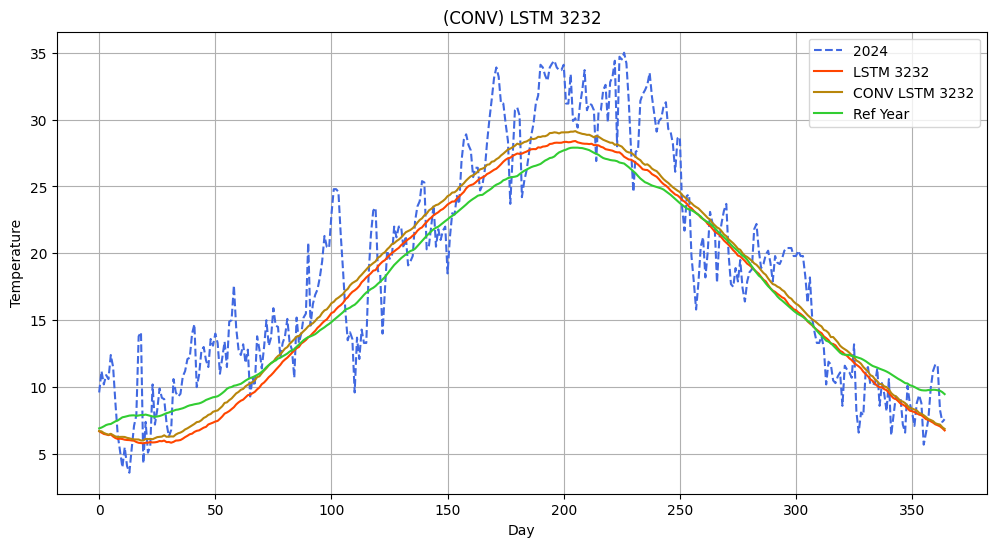

In [27]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_3232[:, 2], label="LSTM 3232", color='orangered')
plt.plot(x, Y_conv_lstm_3232[:, 2], label="CONV LSTM 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_6464 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 294.4212 - mae: 14.5321 - val_loss: 129.6247 - val_mae: 8.9143
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 106.0162 - mae: 8.2667 - val_loss: 78.3555 - val_mae: 7.3101
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 75.4608 - mae: 7.2875 - val_loss: 71.2652 - val_mae: 7.1700
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 71.8848 - mae: 7.1847 - val_loss: 70.5595 - val_mae: 7.1690
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 71.6737 - mae: 7.1835 - val_loss: 70.4984 - val_mae: 7.1713
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 71.6181 - mae: 7.1819 - val_loss: 70.4968 - val_mae: 7.1718
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 71.6043 - mae: 7.1803 - val_loss: 70.5067 - val_mae: 7.1720
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 71.6203 - mae: 7.1823 - val_loss: 70.4964 - val_mae: 7.1720
Epoch 9/60
183/183 ━━━━━━━

In [7]:
from tensorflow.keras.models import load_model
lstm_6464 = load_model('models/lstm_6464.keras')
history_lstm_6464_2 = lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_6464.save('models/lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 10.8193 - mae: 2.5938 - val_loss: 11.6831 - val_mae: 2.7341
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.8011 - mae: 2.5911 - val_loss: 11.8162 - val_mae: 2.7505
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 10.8257 - mae: 2.5946 - val_loss: 11.8517 - val_mae: 2.7500
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 10.7335 - mae: 2.5828 - val_loss: 11.5213 - val_mae: 2.7138
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 10.7288 - mae: 2.5817 - val_loss: 11.7242 - val_mae: 2.7329
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.6851 - mae: 2.5761 - val_loss: 11.8149 - val_mae: 2.7456
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 10.6673 - mae: 2.5742 - val_loss: 11.9933 - val_mae: 2.7702
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.6718 - mae: 2.5744 - val_loss: 11.8661 - val_mae: 2.7515
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [8]:
lstm_6464 = tf.keras.models.load_model('models/lstm_6464.keras')

Y_lstm_6464 = lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_6464 = Y_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_6464_pred.csv')

mae_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_6464:.3f}')

rmse_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Mean Absolute Error (MAE): 2.811
Root Mean Squared Error (RMSE): 3.456


In [9]:
conv_lstm_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_6464 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 294.2779 - mae: 14.5271 - val_loss: 130.5581 - val_mae: 8.9472
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 106.6443 - mae: 8.2884 - val_loss: 78.5837 - val_mae: 7.3154
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 75.6016 - mae: 7.2917 - val_loss: 71.3072 - val_mae: 7.1704
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 71.8930 - mae: 7.1868 - val_loss: 70.5643 - val_mae: 7.1690
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 71.6611 - mae: 7.1828 - val_loss: 70.5004 - val_mae: 7.1715
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 71.6001 - mae: 7.1800 - val_loss: 70.4967 - val_mae: 7.1717
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.5587 - mae: 7.1782 - val_loss: 70.5026 - val_mae: 7.1720
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6189 - mae: 7.1813 - val_loss: 70.5047 - val_mae: 7.1723
Epoch 9/50
183/183 ━━━━━━━━━

In [10]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_2 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 15.0160 - mae: 3.0713 - val_loss: 12.8439 - val_mae: 2.8795
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 12.9929 - mae: 2.8521 - val_loss: 11.6435 - val_mae: 2.7521
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 12.1143 - mae: 2.7529 - val_loss: 11.2144 - val_mae: 2.7076
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.7011 - mae: 2.7031 - val_loss: 11.0260 - val_mae: 2.6815
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 11.6086 - mae: 2.6934 - val_loss: 11.1808 - val_mae: 2.7032
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.4371 - mae: 2.6715 - val_loss: 10.8520 - val_mae: 2.6595
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.4112 - mae: 2.6677 - val_loss: 10.7325 - val_mae: 2.6428
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.3073 - mae: 2.6552 - val_loss: 10.7818 - val_mae: 2.6470
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
conv_lstm_6464 = load_model('models/conv_lstm_6464.keras')
history_conv_lstm_6464_3 = conv_lstm_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_6464.save('models/conv_lstm_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 11.1602 - mae: 2.6369 - val_loss: 10.7191 - val_mae: 2.6387
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.1301 - mae: 2.6336 - val_loss: 10.8277 - val_mae: 2.6482
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.0931 - mae: 2.6292 - val_loss: 10.8844 - val_mae: 2.6569
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.0432 - mae: 2.6224 - val_loss: 10.4430 - val_mae: 2.5954
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.0006 - mae: 2.6173 - val_loss: 10.6102 - val_mae: 2.6160
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 10.9362 - mae: 2.6091 - val_loss: 10.3625 - val_mae: 2.5813
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 10.8984 - mae: 2.6046 - val_loss: 10.5728 - val_mae: 2.6126
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 10.8997 - mae: 2.6046 - val_loss: 10.1798 - val_mae: 2.5537
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [10]:
conv_lstm_6464 = tf.keras.models.load_model('models/conv_lstm_6464.keras')

Y_conv_lstm_6464 = conv_lstm_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_6464 = Y_conv_lstm_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_6464_pred.csv')

mae_conv_lstm_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_6464:.3f}')

rmse_conv_lstm_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step
Mean Absolute Error (MAE): 2.758
Root Mean Squared Error (RMSE): 3.389


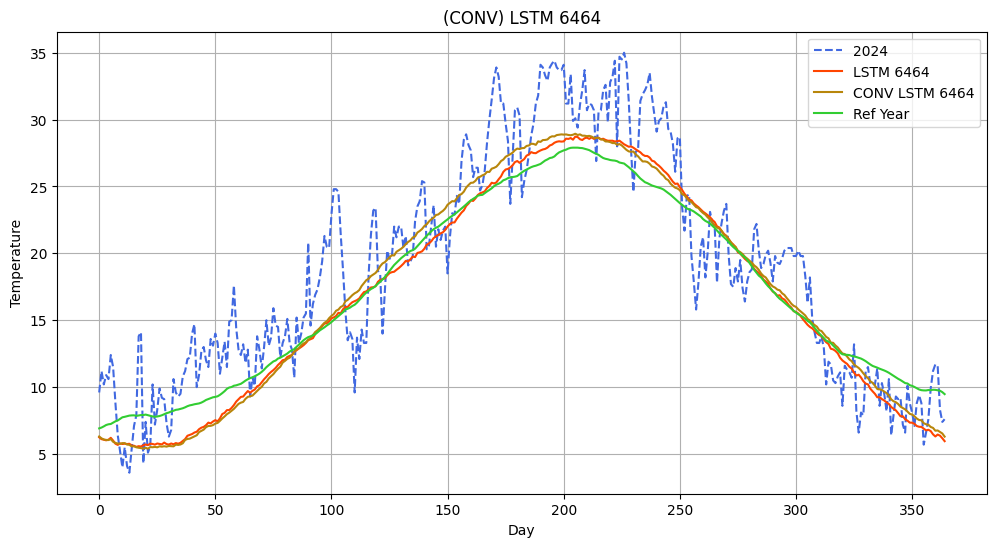

In [12]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_6464[:, 2], label="LSTM 6464", color='orangered')
plt.plot(x, Y_conv_lstm_6464[:, 2], label="CONV LSTM 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [13]:
lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_128128 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 244.4144 - mae: 12.8764 - val_loss: 77.1559 - val_mae: 7.2840
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 73.8900 - mae: 7.2408 - val_loss: 70.5644 - val_mae: 7.1701
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 71.6468 - mae: 7.1826 - val_loss: 70.5313 - val_mae: 7.1730
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 71.6640 - mae: 7.1835 - val_loss: 70.5526 - val_mae: 7.1733
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 71.7121 - mae: 7.1866 - val_loss: 70.6316 - val_mae: 7.1768
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 71.7439 - mae: 7.1876 - val_loss: 70.6095 - val_mae: 7.1756
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 71.7308 - mae: 7.1864 - val_loss: 70.5493 - val_mae: 7.1743
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 71.6785 - mae: 7.1845 - val_loss: 70.6046 - val_mae: 7.1757
Epoch 9/50
183/183 ━━━━━━━━━━

In [15]:
from tensorflow.keras.models import load_model
lstm_128128 = load_model('models/lstm_128128.keras')
history_lstm_128128_2 = lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_128128.save('models/lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 12.5789 - mae: 2.7941 - val_loss: 11.7436 - val_mae: 2.7613
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 12.3496 - mae: 2.7774 - val_loss: 11.6888 - val_mae: 2.7564
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 12.1502 - mae: 2.7540 - val_loss: 11.5351 - val_mae: 2.7393
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 12.0726 - mae: 2.7450 - val_loss: 11.6509 - val_mae: 2.7501
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 11.9745 - mae: 2.7330 - val_loss: 11.3621 - val_mae: 2.7122
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - loss: 11.9829 - mae: 2.7332 - val_loss: 11.9197 - val_mae: 2.7861
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 11.8852 - mae: 2.7222 - val_loss: 11.5510 - val_mae: 2.7365
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 11.7720 - mae: 2.7084 - val_loss: 11.5923 - val_mae: 2.7422
Epoch 9/10
183/183 ━━━━━━━━━━━

In [16]:
lstm_128128 = tf.keras.models.load_model('models/lstm_128128.keras')

Y_lstm_128128 = lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_128128 = Y_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_128128_pred.csv')

mae_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_128128:.3f}')

rmse_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
Mean Absolute Error (MAE): 2.894
Root Mean Squared Error (RMSE): 3.541


In [17]:
conv_lstm_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_lstm_128128 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 243.5694 - mae: 12.8535 - val_loss: 77.6012 - val_mae: 7.2941
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 74.0815 - mae: 7.2471 - val_loss: 70.5639 - val_mae: 7.1698
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.7010 - mae: 7.1850 - val_loss: 70.5404 - val_mae: 7.1730
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6727 - mae: 7.1845 - val_loss: 70.5483 - val_mae: 7.1736
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6909 - mae: 7.1843 - val_loss: 70.5826 - val_mae: 7.1739
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 71.7064 - mae: 7.1857 - val_loss: 70.6128 - val_mae: 7.1754
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 71.6383 - mae: 7.1826 - val_loss: 70.6063 - val_mae: 7.1754
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.6548 - mae: 7.1817 - val_loss: 70.5959 - val_mae: 7.1744
Epoch 9/40
183/183 ━━━━━━━━━━━

In [18]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_2 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 20.4296 - mae: 3.5903 - val_loss: 17.1145 - val_mae: 3.3398
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 15.5027 - mae: 3.1158 - val_loss: 15.5333 - val_mae: 3.1673
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 13.1552 - mae: 2.8681 - val_loss: 17.7109 - val_mae: 3.3398
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 12.1478 - mae: 2.7553 - val_loss: 16.6003 - val_mae: 3.2292
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.7653 - mae: 2.7099 - val_loss: 15.9630 - val_mae: 3.1776
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 11.5519 - mae: 2.6845 - val_loss: 16.5901 - val_mae: 3.2624
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 11.3875 - mae: 2.6640 - val_loss: 15.6190 - val_mae: 3.1585
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 11.3803 - mae: 2.6625 - val_loss: 16.2203 - val_mae: 3.2260
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [20]:
from tensorflow.keras.models import load_model
conv_lstm_128128 = load_model('models/conv_lstm_128128.keras')
history_conv_lstm_128128_3 = conv_lstm_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_128128.save('models/conv_lstm_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 11.0407 - mae: 2.6202 - val_loss: 14.7894 - val_mae: 3.0973
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.9846 - mae: 2.6136 - val_loss: 13.8395 - val_mae: 2.9961
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 10.9375 - mae: 2.6077 - val_loss: 13.4888 - val_mae: 2.9566
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.8800 - mae: 2.6011 - val_loss: 13.9177 - val_mae: 2.9951
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 10.8042 - mae: 2.5911 - val_loss: 13.0898 - val_mae: 2.9055
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 10.7709 - mae: 2.5870 - val_loss: 13.0162 - val_mae: 2.9036
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 10.7256 - mae: 2.5813 - val_loss: 13.0951 - val_mae: 2.9156
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 10.6948 - mae: 2.5777 - val_loss: 12.7418 - val_mae: 2.8703
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [21]:
conv_lstm_128128 = tf.keras.models.load_model('models/conv_lstm_128128.keras')

Y_conv_lstm_128128 = conv_lstm_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_128128 = Y_conv_lstm_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_128128_pred.csv')

mae_conv_lstm_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_128128:.3f}')

rmse_conv_lstm_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Mean Absolute Error (MAE): 2.612
Root Mean Squared Error (RMSE): 3.217


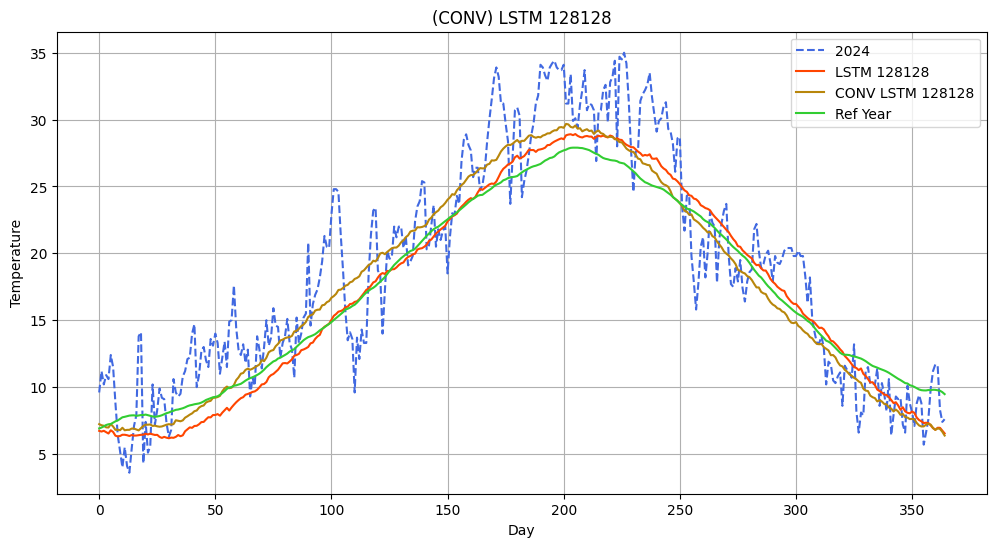

In [22]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_128128[:, 2], label="LSTM 128128", color='orangered')
plt.plot(x, Y_conv_lstm_128128[:, 2], label="CONV LSTM 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_32.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_32 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=80)
gru_32.save('models/gru_32.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 27ms/step - loss: 333.5269 - mae: 15.7849 - val_loss: 230.4066 - val_mae: 12.4977
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 192.5819 - mae: 11.2721 - val_loss: 141.7771 - val_mae: 9.3430
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 123.0129 - mae: 8.8468 - val_loss: 99.6939 - val_mae: 7.9032
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 91.4226 - mae: 7.7782 - val_loss: 81.4352 - val_mae: 7.3836
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 78.4977 - mae: 7.3768 - val_loss: 74.2257 - val_mae: 7.2201
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 73.6641 - mae: 7.2334 - val_loss: 71.6583 - val_mae: 7.1747
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 72.1023 - mae: 7.1888 - val_loss: 70.8305 - val_mae: 7.1674
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.7028 - mae: 7.1812 - val_loss: 70.5797 - val_mae: 7.1685
Epoch 9/80
183/183 ━━━━━

In [8]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_2 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_32.save('models/gru_32.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 43.3357 - mae: 5.3754 - val_loss: 42.3372 - val_mae: 5.3219
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 43.4237 - mae: 5.3798 - val_loss: 42.2390 - val_mae: 5.3136
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 43.3292 - mae: 5.3738 - val_loss: 41.8701 - val_mae: 5.2892
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 43.1947 - mae: 5.3610 - val_loss: 42.0166 - val_mae: 5.2963
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 43.0314 - mae: 5.3485 - val_loss: 41.8622 - val_mae: 5.2856
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.9963 - mae: 5.3436 - val_loss: 41.8402 - val_mae: 5.2819
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 43.0088 - mae: 5.3446 - val_loss: 41.8058 - val_mae: 5.2784
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 42.7265 - mae: 5.3210 - val_loss: 41.6460 - val_mae: 5.2677
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [9]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_3 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=20)
gru_32.save('models/gru_32.keras')

Epoch 1/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 40.9307 - mae: 5.1852 - val_loss: 37.5960 - val_mae: 4.9755
Epoch 2/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 37.4769 - mae: 4.9394 - val_loss: 32.8004 - val_mae: 4.6145
Epoch 3/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 32.6904 - mae: 4.5819 - val_loss: 28.9128 - val_mae: 4.3127
Epoch 4/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 28.9057 - mae: 4.2859 - val_loss: 26.0955 - val_mae: 4.0955
Epoch 5/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 26.6243 - mae: 4.1041 - val_loss: 21.8405 - val_mae: 3.7332
Epoch 6/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 21.7803 - mae: 3.6956 - val_loss: 18.4494 - val_mae: 3.4371
Epoch 7/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 19.0560 - mae: 3.4530 - val_loss: 17.3806 - val_mae: 3.3347
Epoch 8/20
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 17.3543 - mae: 3.2956 - val_loss: 17.4066 - val_mae: 3.3236
Epoch 9/20
183/183 ━━━━━━━━━━━━━

In [10]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_4 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_32.save('models/gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 12.5269 - mae: 2.7985 - val_loss: 13.9680 - val_mae: 2.9974
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 12.4120 - mae: 2.7855 - val_loss: 13.6745 - val_mae: 2.9631
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 12.3505 - mae: 2.7779 - val_loss: 13.5457 - val_mae: 2.9451
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 12.2572 - mae: 2.7671 - val_loss: 14.0946 - val_mae: 3.0034
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 12.1860 - mae: 2.7588 - val_loss: 14.1079 - val_mae: 3.0094
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 12.1395 - mae: 2.7535 - val_loss: 13.5966 - val_mae: 2.9406
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 12.1010 - mae: 2.7487 - val_loss: 13.4836 - val_mae: 2.9279
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 12.0451 - mae: 2.7415 - val_loss: 14.3525 - val_mae: 3.0394
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [13]:
from tensorflow.keras.models import load_model
gru_32 = load_model('models/gru_32.keras')
history_gru_32_5 = gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_32.save('models/gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 11.9292 - mae: 2.7279 - val_loss: 13.7642 - val_mae: 2.9627
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.9210 - mae: 2.7276 - val_loss: 13.6979 - val_mae: 2.9504
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 11.8689 - mae: 2.7207 - val_loss: 14.1819 - val_mae: 2.9938
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 11.8376 - mae: 2.7173 - val_loss: 14.5250 - val_mae: 3.0381
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 11.7864 - mae: 2.7111 - val_loss: 14.4212 - val_mae: 3.0210
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 11.7901 - mae: 2.7118 - val_loss: 14.6685 - val_mae: 3.0453
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 11.7214 - mae: 2.7033 - val_loss: 14.6706 - val_mae: 3.0489
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 11.7086 - mae: 2.7018 - val_loss: 14.7752 - val_mae: 3.0638
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [14]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_32_pred.csv')

mae_gru_32 = mean_absolute_error(Y_test[:, 2], Y_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_32:.3f}')

rmse_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Mean Absolute Error (MAE): 3.060
Root Mean Squared Error (RMSE): 3.748


In [7]:
conv_gru_32 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_32.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_32 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 333.3164 - mae: 15.7792 - val_loss: 231.5111 - val_mae: 12.5365
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 193.6196 - mae: 11.3081 - val_loss: 142.7034 - val_mae: 9.3759
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 123.7734 - mae: 8.8732 - val_loss: 100.2368 - val_mae: 7.9203
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 91.8333 - mae: 7.7915 - val_loss: 81.7018 - val_mae: 7.3901
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 78.6838 - mae: 7.3824 - val_loss: 74.3396 - val_mae: 7.2223
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 73.7367 - mae: 7.2356 - val_loss: 71.7013 - val_mae: 7.1752
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 72.1263 - mae: 7.1894 - val_loss: 70.8451 - val_mae: 7.1674
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.7095 - mae: 7.1814 - val_loss: 70.5843 - val_mae: 7.1685
Epoch 9/60
183/183 ━━━━

In [8]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_2 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 12.9516 - mae: 2.8453 - val_loss: 12.4559 - val_mae: 2.8435
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 12.6114 - mae: 2.8092 - val_loss: 12.1229 - val_mae: 2.8035
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 12.3565 - mae: 2.7798 - val_loss: 12.3275 - val_mae: 2.8241
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 12.2159 - mae: 2.7628 - val_loss: 12.4865 - val_mae: 2.8404
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 12.0896 - mae: 2.7488 - val_loss: 13.0436 - val_mae: 2.8942
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 11.9713 - mae: 2.7344 - val_loss: 12.5135 - val_mae: 2.8357
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.8680 - mae: 2.7234 - val_loss: 12.3844 - val_mae: 2.8250
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.8104 - mae: 2.7163 - val_loss: 12.4192 - val_mae: 2.8257
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [10]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_3 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 11.6333 - mae: 2.6945 - val_loss: 12.5506 - val_mae: 2.8333
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.5487 - mae: 2.6847 - val_loss: 12.2876 - val_mae: 2.8068
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.4962 - mae: 2.6788 - val_loss: 12.0950 - val_mae: 2.7853
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.4190 - mae: 2.6690 - val_loss: 12.0420 - val_mae: 2.7807
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.3863 - mae: 2.6658 - val_loss: 12.3351 - val_mae: 2.8092
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.3690 - mae: 2.6637 - val_loss: 11.8784 - val_mae: 2.7582
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.2961 - mae: 2.6546 - val_loss: 11.8052 - val_mae: 2.7512
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.2814 - mae: 2.6529 - val_loss: 11.8671 - val_mae: 2.7599
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [12]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_4 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 11.1504 - mae: 2.6369 - val_loss: 11.7123 - val_mae: 2.7369
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.1476 - mae: 2.6377 - val_loss: 11.5681 - val_mae: 2.7255
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.0978 - mae: 2.6314 - val_loss: 11.5615 - val_mae: 2.7214
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.0662 - mae: 2.6274 - val_loss: 11.7322 - val_mae: 2.7367
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.0476 - mae: 2.6246 - val_loss: 11.7442 - val_mae: 2.7425
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 11.0783 - mae: 2.6294 - val_loss: 11.4460 - val_mae: 2.7056
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.9729 - mae: 2.6154 - val_loss: 11.3977 - val_mae: 2.6995
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 10.9639 - mae: 2.6144 - val_loss: 11.5654 - val_mae: 2.7197
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [14]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_5 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 10.8703 - mae: 2.6027 - val_loss: 11.3846 - val_mae: 2.6967
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.8389 - mae: 2.5987 - val_loss: 11.4491 - val_mae: 2.7066
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.8271 - mae: 2.5970 - val_loss: 11.6360 - val_mae: 2.7294
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.8046 - mae: 2.5946 - val_loss: 11.5430 - val_mae: 2.7163
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.7639 - mae: 2.5891 - val_loss: 11.4483 - val_mae: 2.7044
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.7765 - mae: 2.5906 - val_loss: 11.4629 - val_mae: 2.7051
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.7594 - mae: 2.5880 - val_loss: 11.8321 - val_mae: 2.7507
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.7588 - mae: 2.5882 - val_loss: 11.3073 - val_mae: 2.6942
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [16]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_6 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 10.7326 - mae: 2.5856 - val_loss: 11.6258 - val_mae: 2.7278
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 10.6963 - mae: 2.5805 - val_loss: 11.5766 - val_mae: 2.7257
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 10.6646 - mae: 2.5766 - val_loss: 11.9532 - val_mae: 2.7665
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.6570 - mae: 2.5757 - val_loss: 11.6752 - val_mae: 2.7350
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.6486 - mae: 2.5751 - val_loss: 11.3309 - val_mae: 2.6896
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.6218 - mae: 2.5710 - val_loss: 11.4405 - val_mae: 2.7095
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 10.6566 - mae: 2.5760 - val_loss: 11.5827 - val_mae: 2.7267
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.6174 - mae: 2.5709 - val_loss: 11.5910 - val_mae: 2.7265
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [18]:
from tensorflow.keras.models import load_model
conv_gru_32 = load_model('models/conv_gru_32.keras')
history_conv_gru_32_7 = conv_gru_32.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_32.save('models/conv_gru_32.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 10.5662 - mae: 2.5642 - val_loss: 11.2862 - val_mae: 2.6898
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.5672 - mae: 2.5652 - val_loss: 11.5005 - val_mae: 2.7157
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5779 - mae: 2.5661 - val_loss: 11.6847 - val_mae: 2.7415
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5566 - mae: 2.5633 - val_loss: 11.2844 - val_mae: 2.6901
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5821 - mae: 2.5670 - val_loss: 11.5090 - val_mae: 2.7201
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5221 - mae: 2.5595 - val_loss: 11.6212 - val_mae: 2.7282
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.5177 - mae: 2.5586 - val_loss: 11.5688 - val_mae: 2.7270
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5185 - mae: 2.5590 - val_loss: 11.7315 - val_mae: 2.7446
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [19]:
conv_gru_32 = tf.keras.models.load_model('models/conv_gru_32.keras')

Y_conv_gru_32 = conv_gru_32.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_32 = Y_conv_gru_32[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_32, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_32_pred.csv')

mae_conv_gru_32 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_32[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_32:.3f}')

rmse_conv_gru_32 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_32[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_32:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Mean Absolute Error (MAE): 3.014
Root Mean Squared Error (RMSE): 3.645


In [21]:
gru_32 = tf.keras.models.load_model('models/gru_32.keras')

Y_gru_32 = gru_32.predict(X)  # shape: (1, 365, 3)
Y_gru_32 = Y_gru_32[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step


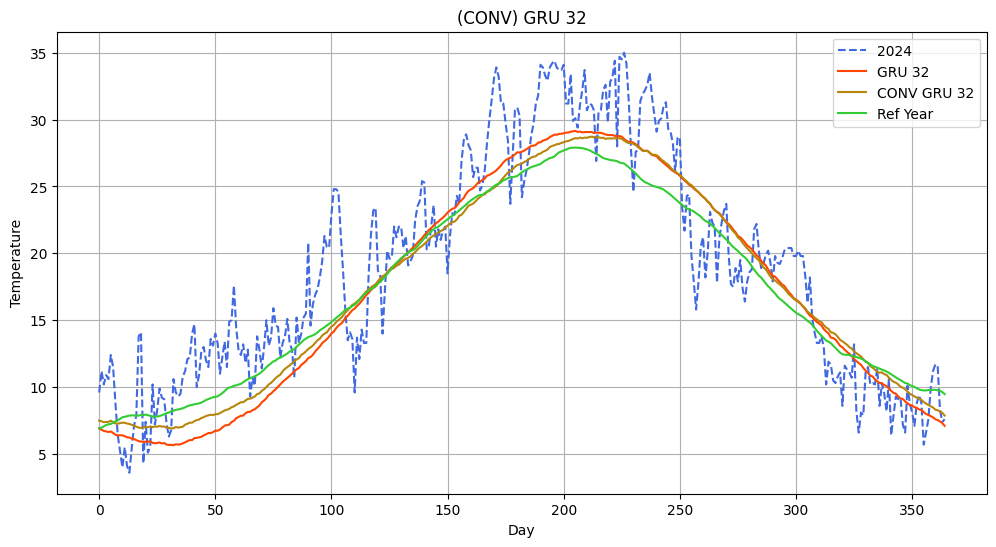

In [22]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_32[:, 2], label="GRU 32", color='orangered')
plt.plot(x, Y_conv_gru_32[:, 2], label="CONV GRU 32", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 32")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [26]:
gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_64.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_64 = gru_64.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_64.save('models/gru_64.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 296.4421 - mae: 14.6117 - val_loss: 140.1621 - val_mae: 9.2857
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 113.4665 - mae: 8.5212 - val_loss: 81.2523 - val_mae: 7.3794
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 77.0877 - mae: 7.3330 - val_loss: 71.7423 - val_mae: 7.1759
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 72.1235 - mae: 7.1926 - val_loss: 70.6145 - val_mae: 7.1680
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.6795 - mae: 7.1826 - val_loss: 70.5033 - val_mae: 7.1709
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6420 - mae: 7.1830 - val_loss: 70.4906 - val_mae: 7.1715
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.5838 - mae: 7.1795 - val_loss: 70.5070 - val_mae: 7.1723
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 71.6295 - mae: 7.1822 - val_loss: 70.5037 - val_mae: 7.1719
Epoch 9/60
183/183 ━━━━━━━━━

In [27]:
gru_64 = tf.keras.models.load_model('models/gru_64.keras')

Y_gru_64 = gru_64.predict(X)  # shape: (1, 365, 3)
Y_gru_64 = Y_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_64_pred.csv')

mae_gru_64 = mean_absolute_error(Y_test[:, 2], Y_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_64:.3f}')

rmse_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
Mean Absolute Error (MAE): 2.773
Root Mean Squared Error (RMSE): 3.401


In [25]:
conv_gru_64 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_64.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_64 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 296.2526 - mae: 14.6078 - val_loss: 140.8910 - val_mae: 9.3117
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 114.0401 - mae: 8.5400 - val_loss: 81.4816 - val_mae: 7.3850
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 77.3157 - mae: 7.3419 - val_loss: 71.7798 - val_mae: 7.1763
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 72.1016 - mae: 7.1909 - val_loss: 70.6191 - val_mae: 7.1680
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.6560 - mae: 7.1811 - val_loss: 70.5089 - val_mae: 7.1709
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.6412 - mae: 7.1825 - val_loss: 70.5012 - val_mae: 7.1718
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 71.5565 - mae: 7.1788 - val_loss: 70.5033 - val_mae: 7.1720
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.5665 - mae: 7.1778 - val_loss: 70.5055 - val_mae: 7.1719
Epoch 9/40
183/183 ━━━━━━━━━

In [27]:
from tensorflow.keras.models import load_model
conv_gru_64 = load_model('models/conv_gru_64.keras')
history_conv_gru_64_2 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 11.4889 - mae: 2.6745 - val_loss: 11.8291 - val_mae: 2.7595
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 11.3690 - mae: 2.6595 - val_loss: 11.9454 - val_mae: 2.7715
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.2937 - mae: 2.6504 - val_loss: 12.6662 - val_mae: 2.8443
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.1927 - mae: 2.6381 - val_loss: 11.7881 - val_mae: 2.7523
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.1574 - mae: 2.6338 - val_loss: 11.4961 - val_mae: 2.7173
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 11.0411 - mae: 2.6202 - val_loss: 12.2866 - val_mae: 2.7928
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 10.9547 - mae: 2.6101 - val_loss: 11.7126 - val_mae: 2.7327
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.8698 - mae: 2.5997 - val_loss: 11.6723 - val_mae: 2.7296
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [29]:
from tensorflow.keras.models import load_model
conv_gru_64 = load_model('models/conv_gru_64.keras')
history_conv_gru_64_3 = conv_gru_64.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_gru_64.save('models/conv_gru_64.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 10.7534 - mae: 2.5853 - val_loss: 11.7214 - val_mae: 2.7277
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.7351 - mae: 2.5835 - val_loss: 11.5773 - val_mae: 2.7123
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.6762 - mae: 2.5761 - val_loss: 11.6345 - val_mae: 2.7182
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 10.6761 - mae: 2.5762 - val_loss: 11.5147 - val_mae: 2.7018
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.6274 - mae: 2.5697 - val_loss: 11.2260 - val_mae: 2.6681
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 10.5980 - mae: 2.5664 - val_loss: 11.8869 - val_mae: 2.7467
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5759 - mae: 2.5636 - val_loss: 11.3023 - val_mae: 2.6747
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 10.5812 - mae: 2.5641 - val_loss: 11.4957 - val_mae: 2.6954
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [30]:
conv_gru_64 = tf.keras.models.load_model('models/conv_gru_64.keras')

Y_conv_gru_64 = conv_gru_64.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_64 = Y_conv_gru_64[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_64, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_64_pred.csv')

mae_conv_gru_64 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_64[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_64:.3f}')

rmse_conv_gru_64 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_64[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_64:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
Mean Absolute Error (MAE): 2.666
Root Mean Squared Error (RMSE): 3.290


In [28]:
conv_gru_64 = tf.keras.models.load_model('models/conv_gru_64.keras')

Y_conv_gru_64 = conv_gru_64.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_64 = Y_conv_gru_64[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


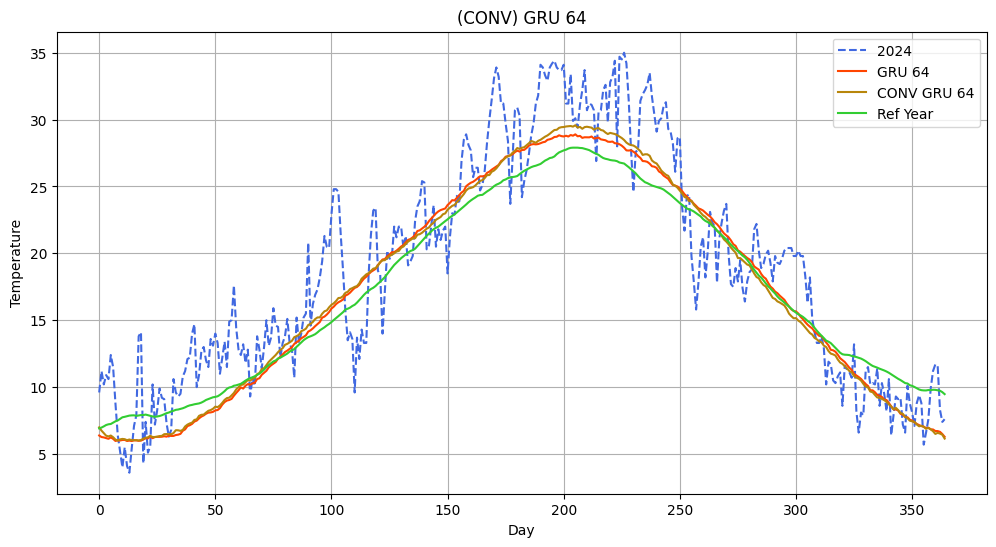

In [29]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_64[:, 2], label="GRU 64", color='orangered')
plt.plot(x, Y_conv_gru_64[:, 2], label="CONV GRU 64", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 64")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [33]:
gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_128.save('models/gru_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 245.1575 - mae: 12.9161 - val_loss: 79.7473 - val_mae: 7.3446
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 74.9845 - mae: 7.2742 - val_loss: 70.6011 - val_mae: 7.1689
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.6648 - mae: 7.1832 - val_loss: 70.5096 - val_mae: 7.1722
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.7165 - mae: 7.1866 - val_loss: 70.5121 - val_mae: 7.1720
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.6648 - mae: 7.1837 - val_loss: 70.5627 - val_mae: 7.1742
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.7235 - mae: 7.1867 - val_loss: 70.5512 - val_mae: 7.1736
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6781 - mae: 7.1845 - val_loss: 70.5183 - val_mae: 7.1730
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.7229 - mae: 7.1869 - val_loss: 70.5733 - val_mae: 7.1749
Epoch 9/40
183/183 ━━━━━━━━━━━

In [35]:
from tensorflow.keras.models import load_model
gru_128 = load_model('models/gru_128.keras')
history_gru_128_2 = gru_128.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_128.save('models/gru_128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 10.9999 - mae: 2.6162 - val_loss: 10.7823 - val_mae: 2.6224
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 10.8981 - mae: 2.6032 - val_loss: 10.7731 - val_mae: 2.6251
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 10.8222 - mae: 2.5944 - val_loss: 11.0375 - val_mae: 2.6527
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 10.7491 - mae: 2.5854 - val_loss: 11.0114 - val_mae: 2.6495
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 10.7214 - mae: 2.5819 - val_loss: 11.3674 - val_mae: 2.6906
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.8441 - mae: 2.5976 - val_loss: 11.4031 - val_mae: 2.6996
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 10.6524 - mae: 2.5737 - val_loss: 11.9260 - val_mae: 2.7598
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 10.5972 - mae: 2.5674 - val_loss: 12.1012 - val_mae: 2.7864
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [36]:
gru_128 = tf.keras.models.load_model('models/gru_128.keras')

Y_gru_128 = gru_128.predict(X)  # shape: (1, 365, 3)
Y_gru_128 = Y_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128_pred.csv')

mae_gru_128 = mean_absolute_error(Y_test[:, 2], Y_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128:.3f}')

rmse_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Mean Absolute Error (MAE): 2.559
Root Mean Squared Error (RMSE): 3.154


In [29]:
conv_gru_128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128 = conv_gru_128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_128.save('models/conv_gru_128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 244.8383 - mae: 12.9081 - val_loss: 79.9468 - val_mae: 7.3493
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 75.0571 - mae: 7.2747 - val_loss: 70.6018 - val_mae: 7.1690
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 71.6660 - mae: 7.1831 - val_loss: 70.5131 - val_mae: 7.1726
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 71.6860 - mae: 7.1846 - val_loss: 70.5606 - val_mae: 7.1738
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 71.6956 - mae: 7.1851 - val_loss: 70.5347 - val_mae: 7.1733
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 71.6658 - mae: 7.1837 - val_loss: 70.5919 - val_mae: 7.1756
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 71.7358 - mae: 7.1877 - val_loss: 70.6478 - val_mae: 7.1774
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 71.8103 - mae: 7.1905 - val_loss: 70.5990 - val_mae: 7.1698
Epoch 9/40
183/183 ━━━━━━━━━━━

In [30]:
conv_gru_128 = tf.keras.models.load_model('models/conv_gru_128.keras')

Y_conv_gru_128 = conv_gru_128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128 = Y_conv_gru_128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128_pred.csv')

mae_conv_gru_128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128:.3f}')

rmse_conv_gru_128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
Mean Absolute Error (MAE): 2.858
Root Mean Squared Error (RMSE): 3.501


In [32]:
gru_128 = tf.keras.models.load_model('models/gru_128.keras')

Y_gru_128 = gru_128.predict(X)  # shape: (1, 365, 3)
Y_gru_128 = Y_gru_128[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step


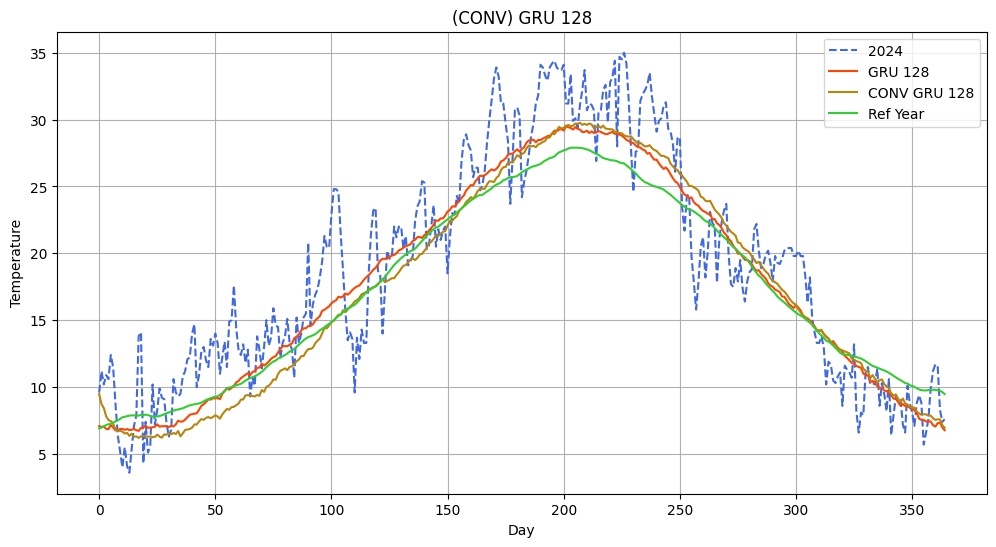

In [33]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128[:, 2], label="GRU 128", color='orangered')
plt.plot(x, Y_conv_gru_128[:, 2], label="CONV GRU 128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_3232 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=80)
gru_3232.save('models/gru_3232.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - loss: 331.3036 - mae: 15.7172 - val_loss: 223.6715 - val_mae: 12.2636
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 186.6250 - mae: 11.0667 - val_loss: 137.0386 - val_mae: 9.1756
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 119.2115 - mae: 8.7148 - val_loss: 97.0694 - val_mae: 7.8217
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 89.4601 - mae: 7.7151 - val_loss: 80.1807 - val_mae: 7.3528
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 77.6276 - mae: 7.3510 - val_loss: 73.6999 - val_mae: 7.2098
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 73.3353 - mae: 7.2240 - val_loss: 71.4634 - val_mae: 7.1722
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - loss: 71.9978 - mae: 7.1863 - val_loss: 70.7653 - val_mae: 7.1672
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 71.6753 - mae: 7.1808 - val_loss: 70.5592 - val_mae: 7.1689
Epoch 9/80
183/183 ━━━━

In [9]:
from tensorflow.keras.models import load_model
gru_3232 = load_model('models/gru_3232.keras')
history_gru_3232_2 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_3232.save('models/gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 10.8879 - mae: 2.6012 - val_loss: 12.3914 - val_mae: 2.8360
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 10.8775 - mae: 2.6007 - val_loss: 12.1185 - val_mae: 2.8005
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 10.8023 - mae: 2.5904 - val_loss: 12.3476 - val_mae: 2.8310
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 10.7874 - mae: 2.5893 - val_loss: 12.4467 - val_mae: 2.8363
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.7216 - mae: 2.5805 - val_loss: 13.2401 - val_mae: 2.9284
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.6996 - mae: 2.5787 - val_loss: 13.2497 - val_mae: 2.9299
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.6606 - mae: 2.5738 - val_loss: 13.3798 - val_mae: 2.9368
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 10.6450 - mae: 2.5720 - val_loss: 13.8179 - val_mae: 2.9833
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [11]:
from tensorflow.keras.models import load_model
gru_3232 = load_model('models/gru_3232.keras')
history_gru_3232_3 = gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_3232.save('models/gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 10.5882 - mae: 2.5655 - val_loss: 13.1373 - val_mae: 2.9096
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.5326 - mae: 2.5585 - val_loss: 13.7828 - val_mae: 2.9762
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.5189 - mae: 2.5573 - val_loss: 13.1955 - val_mae: 2.9171
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.5075 - mae: 2.5554 - val_loss: 13.0819 - val_mae: 2.9000
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.4769 - mae: 2.5518 - val_loss: 13.1418 - val_mae: 2.9068
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 10.4578 - mae: 2.5495 - val_loss: 13.6746 - val_mae: 2.9593
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.4409 - mae: 2.5474 - val_loss: 13.0785 - val_mae: 2.9001
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 10.4293 - mae: 2.5458 - val_loss: 12.9759 - val_mae: 2.8892
Epoch 9/10
183/183 ━━━━━━━━━━━

In [12]:
gru_3232 = tf.keras.models.load_model('models/gru_3232.keras')

Y_gru_3232 = gru_3232.predict(X)  # shape: (1, 365, 3)
Y_gru_3232 = Y_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_3232_pred.csv')

mae_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_3232:.3f}')

rmse_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
Mean Absolute Error (MAE): 3.059
Root Mean Squared Error (RMSE): 3.713


In [15]:
conv_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_3232.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_3232 = conv_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_gru_3232.save('models/conv_gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 331.6916 - mae: 15.7272 - val_loss: 224.4679 - val_mae: 12.2903
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 187.4328 - mae: 11.0933 - val_loss: 137.5530 - val_mae: 9.1937
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 119.7074 - mae: 8.7311 - val_loss: 97.3605 - val_mae: 7.8308
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 89.6746 - mae: 7.7232 - val_loss: 80.3137 - val_mae: 7.3560
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 77.6800 - mae: 7.3516 - val_loss: 73.7574 - val_mae: 7.2110
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 73.4012 - mae: 7.2260 - val_loss: 71.4845 - val_mae: 7.1725
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 71.9790 - mae: 7.1859 - val_loss: 70.7715 - val_mae: 7.1673
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 71.6235 - mae: 7.1764 - val_loss: 70.5633 - val_mae: 7.1688
Epoch 9/60
183/183 ━━━━━

In [16]:
conv_gru_3232 = tf.keras.models.load_model('models/conv_gru_3232.keras')

Y_conv_gru_3232 = conv_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_3232 = Y_conv_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_3232_pred.csv')

mae_conv_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_3232:.3f}')

rmse_conv_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Mean Absolute Error (MAE): 2.813
Root Mean Squared Error (RMSE): 3.454


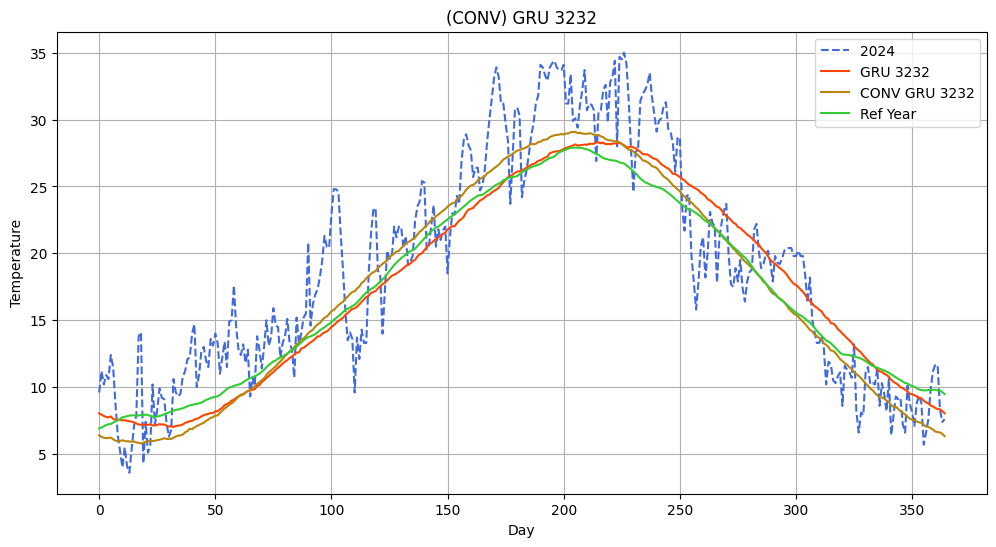

In [17]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_3232[:, 2], label="GRU 3232", color='orangered')
plt.plot(x, Y_conv_gru_3232[:, 2], label="CONV GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [18]:
gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_6464 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
gru_6464.save('models/gru_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - loss: 295.0536 - mae: 14.5625 - val_loss: 135.9556 - val_mae: 9.1375
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 110.4603 - mae: 8.4175 - val_loss: 80.0751 - val_mae: 7.3509
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 76.4519 - mae: 7.3156 - val_loss: 71.5372 - val_mae: 7.1731
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 72.0355 - mae: 7.1903 - val_loss: 70.5864 - val_mae: 7.1683
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 71.6312 - mae: 7.1807 - val_loss: 70.5051 - val_mae: 7.1713
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 71.6502 - mae: 7.1829 - val_loss: 70.4950 - val_mae: 7.1719
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 71.6016 - mae: 7.1809 - val_loss: 70.4845 - val_mae: 7.1718
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 71.6331 - mae: 7.1825 - val_loss: 70.5076 - val_mae: 7.1723
Epoch 9/60
183/183 ━━━━━━━━

In [30]:
from tensorflow.keras.models import load_model
gru_6464 = load_model('models/gru_6464.keras')
history_gru_6464_2 = gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_6464.save('models/gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 10.6283 - mae: 2.5687 - val_loss: 12.0749 - val_mae: 2.8131
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 10.5669 - mae: 2.5615 - val_loss: 12.0649 - val_mae: 2.8090
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 10.5123 - mae: 2.5544 - val_loss: 12.0140 - val_mae: 2.8003
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 10.4576 - mae: 2.5474 - val_loss: 12.4343 - val_mae: 2.8517
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 10.4243 - mae: 2.5433 - val_loss: 12.0947 - val_mae: 2.8099
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 10.3805 - mae: 2.5375 - val_loss: 12.5503 - val_mae: 2.8633
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 10.3538 - mae: 2.5348 - val_loss: 12.7314 - val_mae: 2.8868
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - loss: 10.3300 - mae: 2.5320 - val_loss: 12.6652 - val_mae: 2.8777
Epoch 9/10
183/183 ━━━━━━━━━━

In [31]:
gru_6464 = tf.keras.models.load_model('models/gru_6464.keras')

Y_gru_6464 = gru_6464.predict(X)  # shape: (1, 365, 3)
Y_gru_6464 = Y_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_6464_pred.csv')

mae_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_6464:.3f}')

rmse_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Mean Absolute Error (MAE): 2.733
Root Mean Squared Error (RMSE): 3.361


In [20]:
conv_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_6464.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_6464 = conv_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_gru_6464.save('models/conv_gru_6464.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 295.0749 - mae: 14.5631 - val_loss: 137.2313 - val_mae: 9.1826
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 111.3775 - mae: 8.4494 - val_loss: 80.4394 - val_mae: 7.3597
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 76.6222 - mae: 7.3211 - val_loss: 71.6103 - val_mae: 7.1741
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 72.0534 - mae: 7.1914 - val_loss: 70.5979 - val_mae: 7.1684
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 71.6123 - mae: 7.1799 - val_loss: 70.4993 - val_mae: 7.1711
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6037 - mae: 7.1802 - val_loss: 70.4955 - val_mae: 7.1719
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 71.5953 - mae: 7.1805 - val_loss: 70.4939 - val_mae: 7.1719
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 71.6083 - mae: 7.1808 - val_loss: 70.5068 - val_mae: 7.1722
Epoch 9/50
183/183 ━━━━━━━━━

In [21]:
conv_gru_6464 = tf.keras.models.load_model('models/conv_gru_6464.keras')

Y_conv_gru_6464 = conv_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_6464 = Y_conv_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_6464_pred.csv')

mae_conv_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_6464:.3f}')

rmse_conv_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Mean Absolute Error (MAE): 2.713
Root Mean Squared Error (RMSE): 3.349


In [32]:
conv_gru_6464 = tf.keras.models.load_model('models/conv_gru_6464.keras')

Y_conv_gru_6464 = conv_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_6464 = Y_conv_gru_6464[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


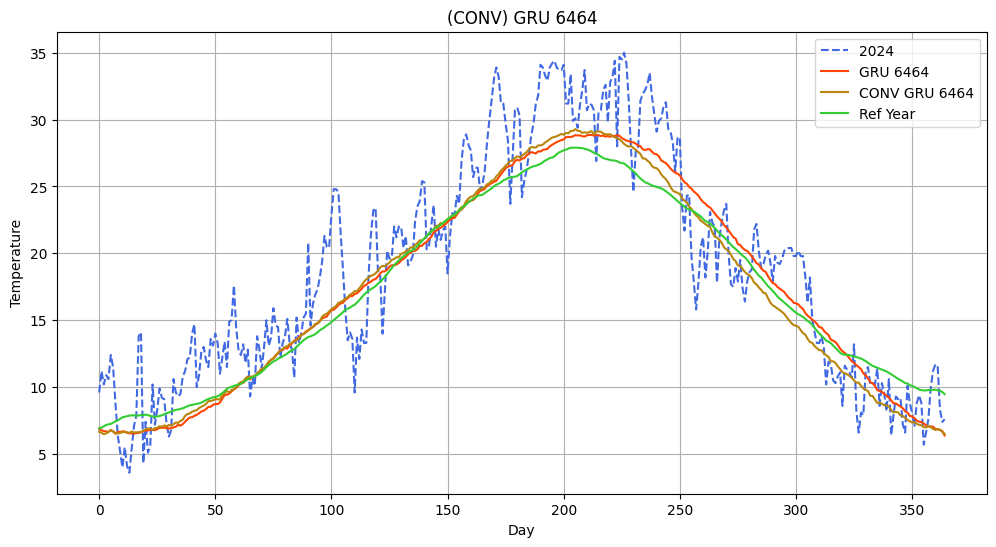

In [33]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_6464[:, 2], label="GRU 6464", color='orangered')
plt.plot(x, Y_conv_gru_6464[:, 2], label="CONV GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [23]:
gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_gru_128128 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
gru_128128.save('models/gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 244.6594 - mae: 12.8998 - val_loss: 79.1316 - val_mae: 7.3297
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 74.7037 - mae: 7.2650 - val_loss: 70.5807 - val_mae: 7.1687
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 71.6437 - mae: 7.1820 - val_loss: 70.5664 - val_mae: 7.1735
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 71.6418 - mae: 7.1819 - val_loss: 70.5470 - val_mae: 7.1729
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 71.6847 - mae: 7.1855 - val_loss: 70.5528 - val_mae: 7.1738
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 71.6638 - mae: 7.1831 - val_loss: 70.5447 - val_mae: 7.1734
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 71.7224 - mae: 7.1869 - val_loss: 70.5809 - val_mae: 7.1748
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 71.6690 - mae: 7.1848 - val_loss: 70.5538 - val_mae: 7.1740
Epoch 9/40
183/183 ━━━━━━━━━

In [25]:
from tensorflow.keras.models import load_model
gru_128128 = load_model('models/gru_128128.keras')
history_gru_128128_2 = gru_128128.fit(train_ds, validation_data=valid_ds, epochs=10)
gru_128128.save('models/gru_128128.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 10.8524 - mae: 2.5966 - val_loss: 11.9867 - val_mae: 2.7843
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 10.7045 - mae: 2.5775 - val_loss: 12.2835 - val_mae: 2.8223
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 10.6253 - mae: 2.5684 - val_loss: 12.2481 - val_mae: 2.8119
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.5482 - mae: 2.5583 - val_loss: 12.5385 - val_mae: 2.8438
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.4567 - mae: 2.5466 - val_loss: 12.2451 - val_mae: 2.8083
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 10.4293 - mae: 2.5432 - val_loss: 12.7381 - val_mae: 2.8699
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.3762 - mae: 2.5367 - val_loss: 12.2686 - val_mae: 2.8068
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 10.3125 - mae: 2.5281 - val_loss: 12.6977 - val_mae: 2.8539
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [26]:
gru_128128 = tf.keras.models.load_model('models/gru_128128.keras')

Y_gru_128128 = gru_128128.predict(X)  # shape: (1, 365, 3)
Y_gru_128128 = Y_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/gru_128128_pred.csv')

mae_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_gru_128128:.3f}')

rmse_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Mean Absolute Error (MAE): 2.721
Root Mean Squared Error (RMSE): 3.362


In [27]:
conv_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_gru_128128.compile(loss="mse", optimizer="adam", metrics=["mae"])
history_conv_gru_128128 = conv_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_gru_128128.save('models/conv_gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - loss: 244.6243 - mae: 12.8969 - val_loss: 79.3938 - val_mae: 7.3362
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 74.7627 - mae: 7.2664 - val_loss: 70.5992 - val_mae: 7.1694
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6655 - mae: 7.1833 - val_loss: 70.5464 - val_mae: 7.1728
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6308 - mae: 7.1819 - val_loss: 70.5307 - val_mae: 7.1727
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6784 - mae: 7.1838 - val_loss: 70.5331 - val_mae: 7.1729
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 71.6981 - mae: 7.1860 - val_loss: 70.5628 - val_mae: 7.1740
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 71.7104 - mae: 7.1857 - val_loss: 70.5069 - val_mae: 7.1729
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 71.7263 - mae: 7.1867 - val_loss: 70.6348 - val_mae: 7.1760
Epoch 9/40
183/183 ━━━━━━━━━━━

In [28]:
conv_gru_128128 = tf.keras.models.load_model('models/conv_gru_128128.keras')

Y_conv_gru_128128 = conv_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_gru_128128 = Y_conv_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_gru_128128_pred.csv')

mae_conv_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_gru_128128:.3f}')

rmse_conv_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Mean Absolute Error (MAE): 2.552
Root Mean Squared Error (RMSE): 3.210


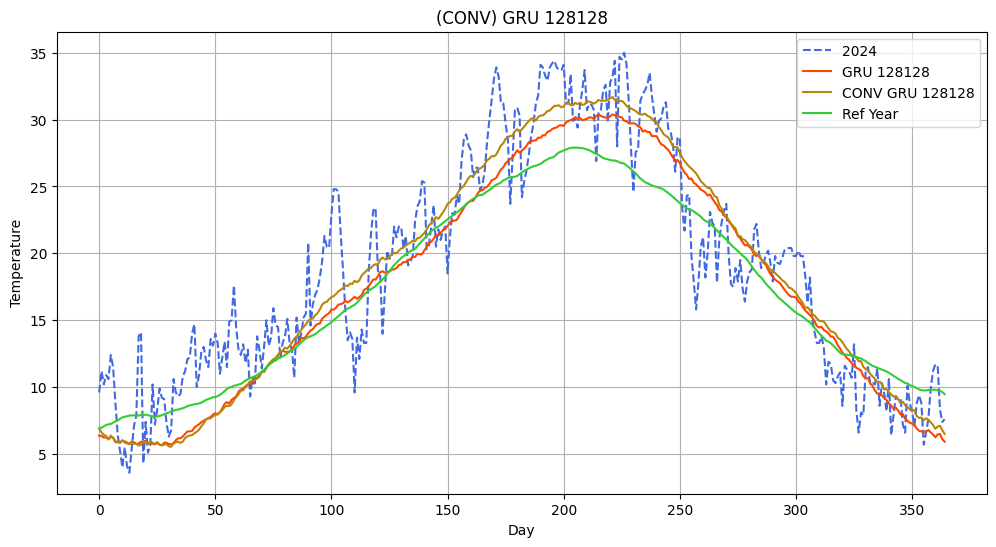

In [29]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_gru_128128[:, 2], label="GRU 128128", color='orangered')
plt.plot(x, Y_conv_gru_128128[:, 2], label="CONV GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [30]:
lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_3232 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=80)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - loss: 330.9914 - mae: 15.7017 - val_loss: 217.5464 - val_mae: 12.0480
Epoch 2/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - loss: 181.2203 - mae: 10.8787 - val_loss: 132.6101 - val_mae: 9.0195
Epoch 3/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 115.6635 - mae: 8.5909 - val_loss: 94.6583 - val_mae: 7.7488
Epoch 4/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 87.7638 - mae: 7.6629 - val_loss: 79.0496 - val_mae: 7.3260
Epoch 5/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 76.8615 - mae: 7.3278 - val_loss: 73.2398 - val_mae: 7.2010
Epoch 6/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 73.0626 - mae: 7.2162 - val_loss: 71.2982 - val_mae: 7.1703
Epoch 7/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 71.9486 - mae: 7.1862 - val_loss: 70.7116 - val_mae: 7.1672
Epoch 8/80
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - loss: 71.6551 - mae: 7.1799 - val_loss: 70.5444 - val_mae: 7.1692
Epoch 9/80
183/183 ━━━

In [32]:
from tensorflow.keras.models import load_model
lstm_gru_3232 = load_model('models/lstm_gru_3232.keras')
history_lstm_gru_3232_2 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - loss: 10.9457 - mae: 2.6099 - val_loss: 13.1673 - val_mae: 2.8930
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 10.9172 - mae: 2.6062 - val_loss: 13.1897 - val_mae: 2.8948
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 10.8968 - mae: 2.6037 - val_loss: 12.9221 - val_mae: 2.8652
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.8627 - mae: 2.5994 - val_loss: 13.1409 - val_mae: 2.8879
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 10.8425 - mae: 2.5963 - val_loss: 13.0642 - val_mae: 2.8805
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 10.8188 - mae: 2.5939 - val_loss: 12.9868 - val_mae: 2.8686
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 10.7933 - mae: 2.5901 - val_loss: 12.9046 - val_mae: 2.8638
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 10.7758 - mae: 2.5878 - val_loss: 13.1494 - val_mae: 2.8932
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [34]:
from tensorflow.keras.models import load_model
lstm_gru_3232 = load_model('models/lstm_gru_3232.keras')
history_lstm_gru_3232_3 = lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_3232.save('models/lstm_gru_3232.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 10.7374 - mae: 2.5831 - val_loss: 13.0850 - val_mae: 2.8778
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 10.7148 - mae: 2.5804 - val_loss: 13.1315 - val_mae: 2.8831
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 10.7017 - mae: 2.5789 - val_loss: 13.5060 - val_mae: 2.9223
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 10.6667 - mae: 2.5746 - val_loss: 13.5233 - val_mae: 2.9332
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 57ms/step - loss: 10.6588 - mae: 2.5734 - val_loss: 13.2146 - val_mae: 2.8906
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - loss: 10.6502 - mae: 2.5720 - val_loss: 14.7420 - val_mae: 3.0540
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.6550 - mae: 2.5732 - val_loss: 13.2822 - val_mae: 2.8937
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 10.6314 - mae: 2.5701 - val_loss: 13.9645 - val_mae: 2.9608
Epoch 9/10
183/183 ━━━━━━━━━━━

In [35]:
lstm_gru_3232 = tf.keras.models.load_model('models/lstm_gru_3232.keras')

Y_lstm_gru_3232 = lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_3232 = Y_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_3232_pred.csv')

mae_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_3232:.3f}')

rmse_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
Mean Absolute Error (MAE): 3.114
Root Mean Squared Error (RMSE): 3.832


In [34]:
conv_lstm_gru_3232 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_3232.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_3232 = conv_lstm_gru_3232.fit(train_ds, validation_data=valid_ds, epochs=60)
conv_lstm_gru_3232.save('models/conv_lstm_gru_3232.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 331.2422 - mae: 15.7092 - val_loss: 220.1142 - val_mae: 12.1368
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 183.5364 - mae: 10.9565 - val_loss: 134.4792 - val_mae: 9.0854
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 117.0970 - mae: 8.6408 - val_loss: 95.6866 - val_mae: 7.7799
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 88.4923 - mae: 7.6865 - val_loss: 79.5395 - val_mae: 7.3376
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 77.1446 - mae: 7.3367 - val_loss: 73.4429 - val_mae: 7.2049
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 73.2125 - mae: 7.2205 - val_loss: 71.3673 - val_mae: 7.1711
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 72.0060 - mae: 7.1885 - val_loss: 70.7311 - val_mae: 7.1672
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 71.6399 - mae: 7.1788 - val_loss: 70.5533 - val_mae: 7.1690
Epoch 9/60
183/183 ━━━━━

In [35]:
conv_lstm_gru_3232 = tf.keras.models.load_model('models/conv_lstm_gru_3232.keras')

Y_conv_lstm_gru_3232 = conv_lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_3232 = Y_conv_lstm_gru_3232[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_3232, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_3232_pred.csv')

mae_conv_lstm_gru_3232 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_3232:.3f}')

rmse_conv_lstm_gru_3232 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_3232[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_3232:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Mean Absolute Error (MAE): 2.660
Root Mean Squared Error (RMSE): 3.282


In [36]:
conv_lstm_gru_3232 = tf.keras.models.load_model('models/conv_lstm_gru_3232.keras')

Y_conv_lstm_gru_3232 = conv_lstm_gru_3232.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_3232 = Y_conv_lstm_gru_3232[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


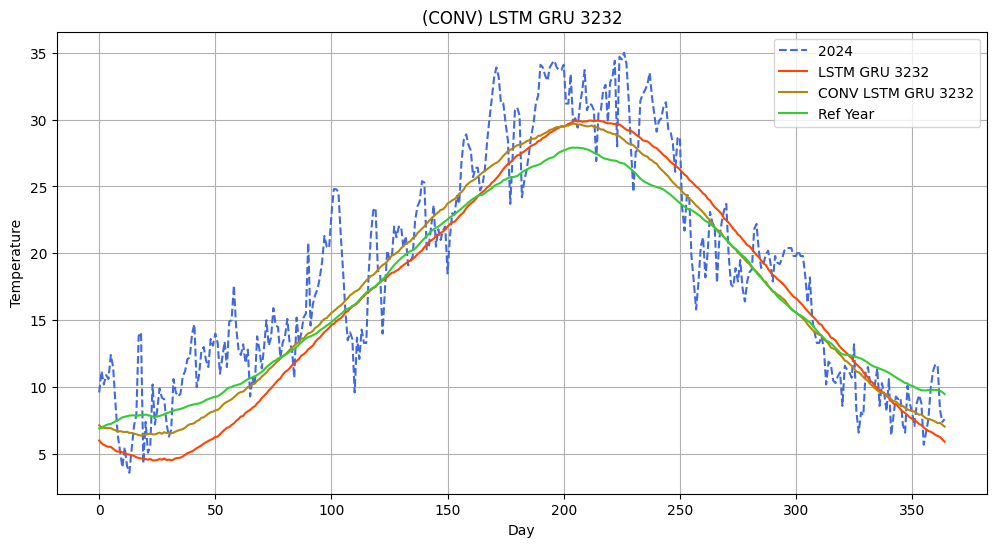

In [37]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_3232[:, 2], label="LSTM GRU 3232", color='orangered')
plt.plot(x, Y_conv_lstm_gru_3232[:, 2], label="CONV LSTM GRU 3232", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 3232")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [7]:
lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_6464= lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=60)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - loss: 293.5886 - mae: 14.5082 - val_loss: 132.3617 - val_mae: 9.0108
Epoch 2/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 108.0112 - mae: 8.3342 - val_loss: 79.1585 - val_mae: 7.3291
Epoch 3/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 75.9279 - mae: 7.3013 - val_loss: 71.3912 - val_mae: 7.1714
Epoch 4/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 71.9396 - mae: 7.1860 - val_loss: 70.5730 - val_mae: 7.1687
Epoch 5/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step - loss: 71.6762 - mae: 7.1835 - val_loss: 70.4988 - val_mae: 7.1712
Epoch 6/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 71.6169 - mae: 7.1819 - val_loss: 70.4954 - val_mae: 7.1717
Epoch 7/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 71.6026 - mae: 7.1802 - val_loss: 70.5048 - val_mae: 7.1719
Epoch 8/60
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 71.6189 - mae: 7.1822 - val_loss: 70.4950 - val_mae: 7.1720
Epoch 9/60
183/183 ━━━━━

In [8]:
from tensorflow.keras.models import load_model
lstm_gru_6464 = load_model('models/lstm_gru_6464.keras')
history_lstm_gru_6464_2 = lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - loss: 11.3882 - mae: 2.6630 - val_loss: 13.6168 - val_mae: 2.9375
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 11.2867 - mae: 2.6512 - val_loss: 12.8045 - val_mae: 2.8548
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 11.3030 - mae: 2.6537 - val_loss: 13.3584 - val_mae: 2.9142
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 11.1845 - mae: 2.6382 - val_loss: 12.9740 - val_mae: 2.8779
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step - loss: 11.2212 - mae: 2.6433 - val_loss: 12.8080 - val_mae: 2.8580
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - loss: 11.0911 - mae: 2.6266 - val_loss: 13.2600 - val_mae: 2.9076
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 11.0322 - mae: 2.6202 - val_loss: 12.8936 - val_mae: 2.8695
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 10.9666 - mae: 2.6115 - val_loss: 13.4933 - val_mae: 2.9269
Epoch 9/10
183/183 ━━━━━━━━━━━

In [10]:
from tensorflow.keras.models import load_model
lstm_gru_6464 = load_model('models/lstm_gru_6464.keras')
history_lstm_gru_6464_3 = lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
lstm_gru_6464.save('models/lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - loss: 10.8116 - mae: 2.5924 - val_loss: 14.1669 - val_mae: 2.9934
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 10.7232 - mae: 2.5813 - val_loss: 13.1943 - val_mae: 2.8944
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 10.6512 - mae: 2.5724 - val_loss: 14.0419 - val_mae: 2.9846
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 10.6423 - mae: 2.5708 - val_loss: 14.2729 - val_mae: 2.9876
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 10.6017 - mae: 2.5664 - val_loss: 14.1990 - val_mae: 2.9896
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 10.5591 - mae: 2.5611 - val_loss: 14.4123 - val_mae: 3.0131
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 10.5364 - mae: 2.5582 - val_loss: 12.8449 - val_mae: 2.8522
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 10.6418 - mae: 2.5710 - val_loss: 14.3501 - val_mae: 3.0064
Epoch 9/10
183/183 ━━━━━━━━━━━━

In [11]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')

Y_lstm_gru_6464 = lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_6464 = Y_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_6464_pred.csv')

mae_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_6464:.3f}')

rmse_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Mean Absolute Error (MAE): 3.097
Root Mean Squared Error (RMSE): 3.771


In [16]:
conv_lstm_gru_6464 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_6464.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_6464 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=50)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 294.1529 - mae: 14.5307 - val_loss: 134.9653 - val_mae: 9.1028
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 109.7630 - mae: 8.3941 - val_loss: 79.8560 - val_mae: 7.3457
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 76.3654 - mae: 7.3145 - val_loss: 71.5025 - val_mae: 7.1726
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 71.9547 - mae: 7.1865 - val_loss: 70.5826 - val_mae: 7.1685
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 71.6129 - mae: 7.1796 - val_loss: 70.4997 - val_mae: 7.1713
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6411 - mae: 7.1820 - val_loss: 70.4946 - val_mae: 7.1717
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.5786 - mae: 7.1793 - val_loss: 70.4978 - val_mae: 7.1719
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 71.6619 - mae: 7.1831 - val_loss: 70.5058 - val_mae: 7.1718
Epoch 9/50
183/183 ━━━━━━━━━

In [38]:
from tensorflow.keras.models import load_model
conv_lstm_gru_6464 = load_model('models/conv_lstm_gru_6464.keras')
history_conv_lstm_gru_6464_2 = conv_lstm_gru_6464.fit(train_ds, validation_data=valid_ds, epochs=10)
conv_lstm_gru_6464.save('models/conv_lstm_gru_6464.keras')

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - loss: 10.8799 - mae: 2.6039 - val_loss: 11.7403 - val_mae: 2.7499
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 10.8388 - mae: 2.5990 - val_loss: 11.8047 - val_mae: 2.7562
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 10.7254 - mae: 2.5845 - val_loss: 11.5015 - val_mae: 2.7164
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 10.6632 - mae: 2.5770 - val_loss: 11.5907 - val_mae: 2.7333
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 10.6026 - mae: 2.5698 - val_loss: 11.8472 - val_mae: 2.7616
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 10.5898 - mae: 2.5677 - val_loss: 11.7380 - val_mae: 2.7469
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 10.5052 - mae: 2.5574 - val_loss: 11.6731 - val_mae: 2.7305
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 10.4870 - mae: 2.5548 - val_loss: 11.8680 - val_mae: 2.7545
Epoch 9/10
183/183 ━━━━━━━━━━━━━

In [39]:
conv_lstm_gru_6464 = tf.keras.models.load_model('models/conv_lstm_gru_6464.keras')

Y_conv_lstm_gru_6464 = conv_lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_6464 = Y_conv_lstm_gru_6464[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_6464, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_6464_pred.csv')

mae_conv_lstm_gru_6464 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_6464:.3f}')

rmse_conv_lstm_gru_6464 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_6464[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_6464:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Mean Absolute Error (MAE): 2.725
Root Mean Squared Error (RMSE): 3.357


In [40]:
lstm_gru_6464 = tf.keras.models.load_model('models/lstm_gru_6464.keras')

Y_lstm_gru_6464 = lstm_gru_6464.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_6464 = Y_lstm_gru_6464[0]  # shape: (365, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step


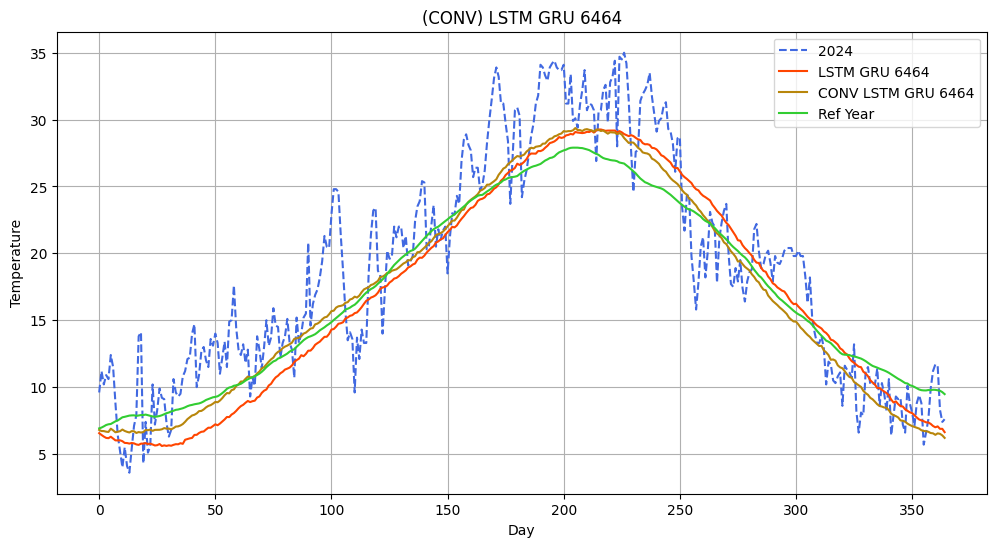

In [41]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_6464[:, 2], label="LSTM GRU 6464", color='orangered')
plt.plot(x, Y_conv_lstm_gru_6464[:, 2], label="CONV LSTM GRU 6464", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 6464")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 

In [19]:
lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_lstm_gru_128128= lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=50)
lstm_gru_128128.save('models/lstm_gru_128128.keras')

Epoch 1/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 243.4972 - mae: 12.8559 - val_loss: 78.5418 - val_mae: 7.3160
Epoch 2/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 74.5100 - mae: 7.2602 - val_loss: 70.5942 - val_mae: 7.1701
Epoch 3/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 71.6786 - mae: 7.1832 - val_loss: 70.5305 - val_mae: 7.1727
Epoch 4/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 71.6054 - mae: 7.1809 - val_loss: 70.5358 - val_mae: 7.1728
Epoch 5/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - loss: 71.6262 - mae: 7.1808 - val_loss: 70.6076 - val_mae: 7.1754
Epoch 6/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - loss: 71.7429 - mae: 7.1872 - val_loss: 70.5752 - val_mae: 7.1741
Epoch 7/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 71.6822 - mae: 7.1836 - val_loss: 70.5365 - val_mae: 7.1737
Epoch 8/50
183/183 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 71.7032 - mae: 7.1860 - val_loss: 70.6974 - val_mae: 7.1780
Epoch 9/50
183/183 ━━━━━━━━━━

In [20]:
lstm_gru_128128 = tf.keras.models.load_model('models/lstm_gru_128128.keras')

Y_lstm_gru_128128 = lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_lstm_gru_128128 = Y_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/lstm_gru_128128_pred.csv')

mae_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_lstm_gru_128128:.3f}')

rmse_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
Mean Absolute Error (MAE): 2.567
Root Mean Squared Error (RMSE): 3.144


In [26]:
conv_lstm_gru_128128 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(None, 5)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3, strides=2, padding="same", activation="relu"),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(365 * 3),
    tf.keras.layers.Reshape((365, 3))
])

conv_lstm_gru_128128.compile(loss='mse', optimizer='adam', metrics=["mae"])
history_conv_lstm_gru_128128 = conv_lstm_gru_128128.fit(train_ds, validation_data=valid_ds, epochs=40)
conv_lstm_gru_128128.save('models/conv_lstm_gru_128128.keras')

Epoch 1/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 244.9829 - mae: 12.9053 - val_loss: 78.7404 - val_mae: 7.3208
Epoch 2/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 74.5540 - mae: 7.2607 - val_loss: 70.5966 - val_mae: 7.1695
Epoch 3/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6721 - mae: 7.1831 - val_loss: 70.5375 - val_mae: 7.1730
Epoch 4/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6335 - mae: 7.1820 - val_loss: 70.5336 - val_mae: 7.1735
Epoch 5/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.6058 - mae: 7.1810 - val_loss: 70.5928 - val_mae: 7.1747
Epoch 6/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 71.6333 - mae: 7.1815 - val_loss: 70.5348 - val_mae: 7.1738
Epoch 7/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 71.6598 - mae: 7.1831 - val_loss: 70.5639 - val_mae: 7.1742
Epoch 8/40
183/183 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 71.6936 - mae: 7.1852 - val_loss: 70.5687 - val_mae: 7.1743
Epoch 9/40
183/183 ━━━━━━━━━━━

In [27]:
conv_lstm_gru_128128 = tf.keras.models.load_model('models/conv_lstm_gru_128128.keras')

Y_conv_lstm_gru_128128 = conv_lstm_gru_128128.predict(X)  # shape: (1, 365, 3)
Y_conv_lstm_gru_128128 = Y_conv_lstm_gru_128128[0]  # shape: (365, 3)

dates = pd.date_range(start='2024-01-01', end='2024-12-31')
dates = dates[dates != '2024-02-29']

df_pred = pd.DataFrame(Y_conv_lstm_gru_128128, columns=['MIN', 'MAX', 'TEMP'], index=dates)
df_pred.to_csv('preds/conv_lstm_gru_128128_pred.csv')

mae_conv_lstm_gru_128128 = mean_absolute_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2])
print(f'Mean Absolute Error (MAE): {mae_conv_lstm_gru_128128:.3f}')

rmse_conv_lstm_gru_128128 = np.sqrt(mean_squared_error(Y_test[:, 2], Y_conv_lstm_gru_128128[:, 2]))
print(f'Root Mean Squared Error (RMSE): {rmse_conv_lstm_gru_128128:.3f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Mean Absolute Error (MAE): 2.751
Root Mean Squared Error (RMSE): 3.440


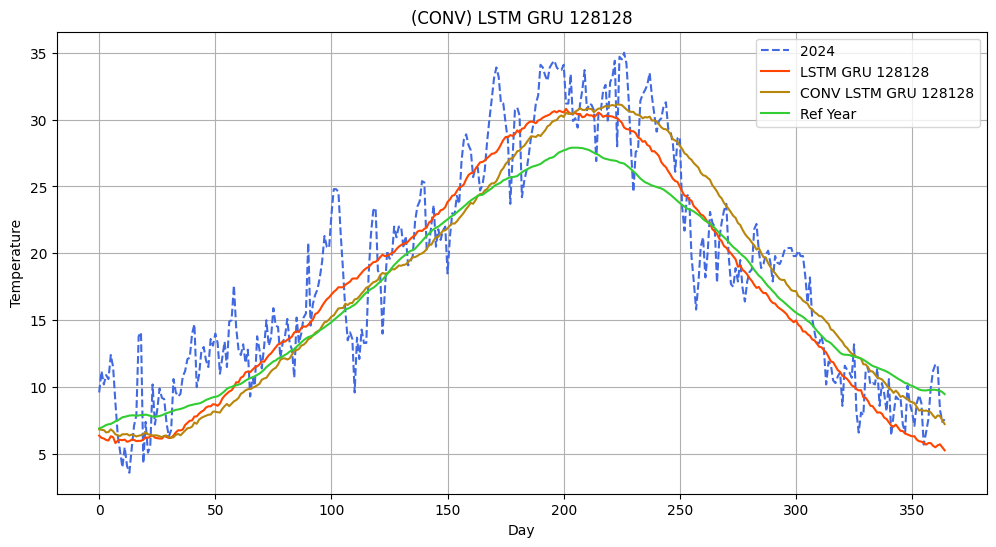

In [28]:
x = np.arange(len(Y_test)) 

Y_ref_smooth = pd.Series(Y_ref[:, 2]).rolling(window=90, min_periods=1, center=True).mean()

plt.figure(figsize=(12, 6))

plt.plot(x, Y_test[:, 2], label="2024", color='royalblue', linestyle='dashed')
plt.plot(x, Y_lstm_gru_128128[:, 2], label="LSTM GRU 128128", color='orangered')
plt.plot(x, Y_conv_lstm_gru_128128[:, 2], label="CONV LSTM GRU 128128", color='darkgoldenrod')
plt.plot(x, Y_ref_smooth, label="Ref Year", color='limegreen')

plt.title("(CONV) LSTM GRU 128128")
plt.xlabel("Day")
plt.ylabel("Temperature")
plt.legend() 
plt.grid(True) 

plt.show() 